<a href="https://colab.research.google.com/github/mipypf/scej-mi/blob/develop/chapter12/scej_mi_chapter12_example_symbolic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MI領域で最もオーソドックスかつ使用頻度の高いテーブルデータタスクを題材にして、デモデータを用いたシンボリック回帰の実例を扱う

### 使用するデータセットの参考文献
- Tamura, R. et al. Materials informatics approach to understand aluminum alloys. Sci Technol Adv Mater 540–551 (2020) doi:10.1080/14686996.2020.1791676

### データセットのダウンロード
- https://www.tandfonline.com/doi/full/10.1080/14686996.2020.1791676#supplemental-material-section からtsta_a_1791676_sm7404.csvをダウンロード

### Google Colabの準備

##### 右上の「接続」をクリックし、ランタイムに接続

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、tsta_a_1791676_sm7404.csvをドラッグ＆ドロップしてアップロード
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

##### ライブラリをインストール

In [3]:
! pip install pysr==1.5.8
! pip install japanize_matplotlib==1.1.3
! pip install adjustText==1.2.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.3/99.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 41.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=a8aae0d5c6ca34aa1d5c703c08f1965b48e64b71144a88ab6e4f32d114936235
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize_matplotlib


### ライブラリをインポート

In [19]:
import os
import re
import warnings

warnings.filterwarnings("ignore")

import pickle

import japanize_matplotlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from adjustText import adjust_text
from pandas import json_normalize
import pysr
from pysr import PySRRegressor
import sklearn
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor, plot_tree
import tqdm
import shap

print("matplotlib:", matplotlib.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("seaborn:", sns.__version__)
print("scikit-learn:", sklearn.__version__)
print("tqdm:", tqdm.__version__)
print("pysr:", pysr.__version__)

from tqdm.notebook import tqdm

matplotlib: 3.10.0
numpy: 2.0.2
pandas: 2.2.2
seaborn: 0.13.2
scikit-learn: 1.6.1
tqdm: 4.67.1
pysr: 1.5.8


In [5]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20

### ファイルのコンフィグ情報を定義

In [6]:
class CFG:
    input_dir = INPUT_FILE_PATH
    output_dir = OUTPUT_FILE_PATH
    random_seed = 42
    exp_no = "exp000"

### データの読み込み

In [7]:
# Google Colabの左部の「ファイル」アイコンをクリックし、tsta_a_1791676_sm7404.csvをドラッグ＆ドロップしてアップロード
data = pd.read_csv(f"{CFG.input_dir}/tsta_a_1791676_sm7404.csv")
data

ID  X  Fe (wt%)  Mn (wt%)  Si (wt%)  Al (wt%)  Mg (wt%)  Ti (wt%)  \
0   A 6005A BE  1      0.18      0.25      0.70     97.88      0.55      0.05   
1   A 6005A BE  4      0.18      0.25      0.70     97.88      0.55      0.05   
2   A 6005A BE  5      0.18      0.25      0.70     97.88      0.55      0.05   
3   A 6005A BE  6      0.18      0.25      0.70     97.88      0.55      0.05   
4   A 6005C BE  1      0.18      0.25      0.65     97.83      0.60      0.05   
5   A 6005C BE  5      0.18      0.25      0.65     97.83      0.60      0.05   
6   A 6005C BE  6      0.18      0.25      0.65     97.83      0.60      0.05   
7    A 6060 BE  4      0.20      0.05      0.45     98.63      0.48      0.05   
8    A 6060 BE  5      0.20      0.05      0.45     98.63      0.48      0.05   
9    A 6060 BE  6      0.20      0.05      0.45     98.63      0.48      0.05   
10   A 6061 BD  4      0.35      0.08      0.60     97.31      1.00      0.08   
11   A 6061 BD  6      0.35      0.08      0.60     97.31      1.00      0.08   
12    A 6061 P  4      0.35      0.08      0.60     97.31      1.00      0.08   
13    A 6061 P  6      0.35      0.08      0.60     97.31      1.00      0.08   
14   A 6063 BD  1      0.18      0.05      0.40     98.50      0.68      0.05   
15   A 6063 BD  4      0.18      0.05      0.40     98.50      0.68      0.05   
16   A 6063 BD  5      0.18      0.05      0.40     98.50      0.68      0.05   
17   A 6063 BD  6      0.18      0.05      0.40     98.50      0.68      0.05   
18    A 6082 P  4      0.25      0.70      1.00     96.83      0.90      0.05   
19    A 6082 P  6      0.25      0.70      1.00     96.83      0.90      0.05   
20    A 6101 P  6      0.25      0.02      0.50     98.52      0.58      0.00   
21    A 6101 P  7      0.25      0.02      0.50     98.52      0.58      0.00   
22   A 6151 FH  6      0.50      0.10      0.90     97.25      0.63      0.08   
23   A 6181 BD  4      0.23      0.08      1.00     97.65      0.80      0.05   
24   A 6181 BD  6      0.23      0.08      1.00     97.65      0.80      0.05   
25   A 6262 BD  6      0.35      0.08      0.60     96.16      1.00      0.08   
26   A 6262 BD  8      0.35      0.08      0.60     96.16      1.00      0.08   
27   A 6262 BD  9      0.35      0.08      0.60     96.16      1.00      0.08   
28    A 6463 S  1      0.18      0.05      0.40     98.60      0.68      0.00   
29    A 6463 S  4      0.18      0.05      0.40     98.60      0.68      0.00   
30    A 6463 S  5      0.18      0.05      0.40     98.60      0.68      0.00   
31    A 6463 S  6      0.18      0.05      0.40     98.60      0.68      0.00   
32   A 6N01 BE  5      0.18      0.25      0.65     97.83      0.60      0.05   
33   A 6N01 BE  6      0.18      0.25      0.65     97.83      0.60      0.05   

    Cu (wt%)  Cr (wt%)  Zn (wt%)  2% proof stress (Mpa)  \
0       0.15      0.15      0.10                    100   
1       0.15      0.15      0.10                     90   
2       0.15      0.15      0.10                    215   
3       0.15      0.15      0.10                    225   
4       0.18      0.15      0.13                    107   
5       0.18      0.15      0.13                    175   
6       0.18      0.15      0.13                    235   
7       0.05      0.03      0.08                     60   
8       0.05      0.03      0.08                    120   
9       0.05      0.03      0.08                    150   
10      0.28      0.20      0.13                    110   
11      0.28      0.20      0.13                    240   
12      0.28      0.20      0.13                    110   
13      0.28      0.20      0.13                    245   
14      0.05      0.05      0.05                     62   
15      0.05      0.05      0.05                     69   
16      0.05      0.05      0.05                    110   
17      0.05      0.05      0.05                    172   
18      0.05      0.13      0.10                    110

### EDA

##### データの列名を確認

In [8]:
columns = data.columns
columns

Index(['ID', 'X', 'Fe (wt%)', 'Mn (wt%)', 'Si (wt%)', 'Al (wt%)', 'Mg (wt%)',
       'Ti (wt%)', 'Cu (wt%)', 'Cr (wt%)', 'Zn (wt%)', '2% proof stress (Mpa)',
       'Tensile strength (Mpa)', 'Elongation (%)'],
      dtype='object')

##### データの欠損を確認

In [9]:
data.isnull().sum()

ID                        0
X                         0
Fe (wt%)                  0
Mn (wt%)                  0
Si (wt%)                  0
Al (wt%)                  0
Mg (wt%)                  0
Ti (wt%)                  0
Cu (wt%)                  0
Cr (wt%)                  0
Zn (wt%)                  0
2% proof stress (Mpa)     0
Tensile strength (Mpa)    0
Elongation (%)            0
dtype: int64

##### IDごとに個数をカウント

In [10]:
data['ID'].value_counts()

ID
A 6005A BE    4
A 6463 S      4
A 6063 BD     4
A 6005C BE    3
A 6060 BE     3
A 6262 BD     3
A 6061 BD     2
A 6061 P      2
A 6082 P      2
A 6181 BD     2
A 6101 P      2
A 6N01 BE     2
A 6151 FH     1
Name: count, dtype: int64

##### IDごとのXの値を可視化

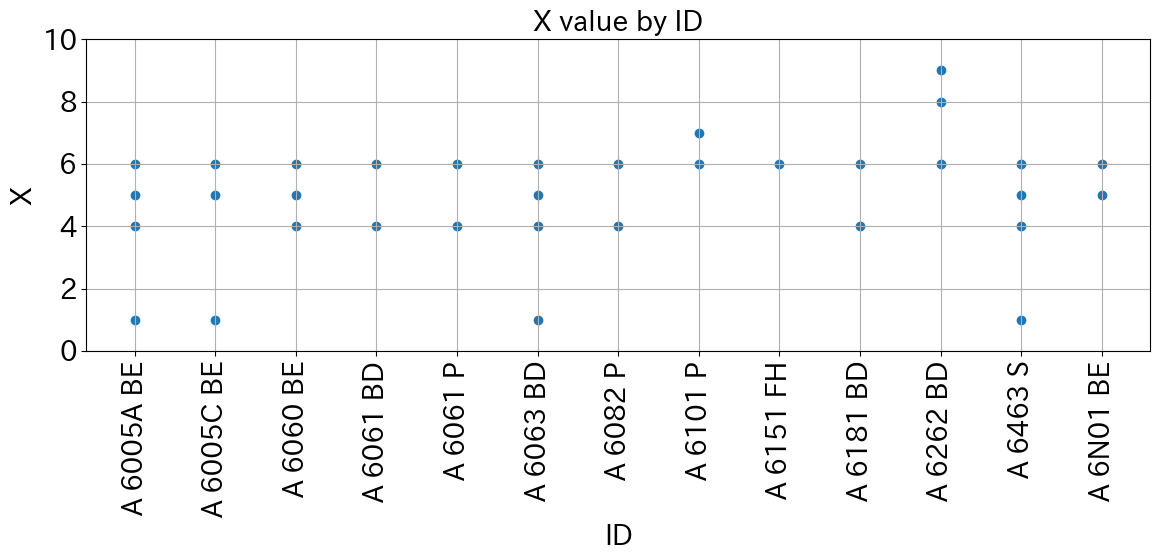

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(data["ID"], data["X"])
plt.xlabel("ID")
plt.ylabel("X")
plt.title("X value by ID")
plt.xticks(rotation=90)
plt.ylim(bottom=0)
plt.ylim(top=10)
plt.grid(True)
plt.tight_layout()
plt.show()

##### 2% proof stress (Mpa)のヒストグラムを作成

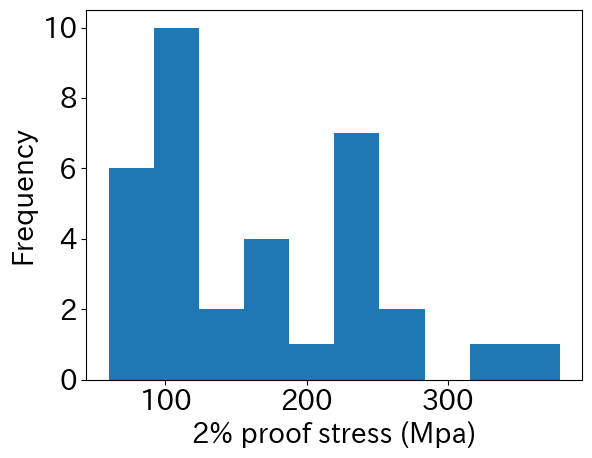

In [12]:
plt.hist(data["2% proof stress (Mpa)"])
plt.xlabel("2% proof stress (Mpa)")
plt.ylabel("Frequency")
plt.show()

### 使用する説明変数をリストとして定義

In [21]:
data.columns = [
    re.sub(r"\s*\([^)]*\)", "", col)  # 括弧と中身を削除
    .replace(" ", "_")                # 空白をアンダースコアに
    .replace("%", "")                 # % を削除
    for col in data.columns
]
data

ID  X    Fe    Mn    Si     Al    Mg    Ti    Cu    Cr    Zn  \
0   A 6005A BE  1  0.18  0.25  0.70  97.88  0.55  0.05  0.15  0.15  0.10   
1   A 6005A BE  4  0.18  0.25  0.70  97.88  0.55  0.05  0.15  0.15  0.10   
2   A 6005A BE  5  0.18  0.25  0.70  97.88  0.55  0.05  0.15  0.15  0.10   
3   A 6005A BE  6  0.18  0.25  0.70  97.88  0.55  0.05  0.15  0.15  0.10   
4   A 6005C BE  1  0.18  0.25  0.65  97.83  0.60  0.05  0.18  0.15  0.13   
5   A 6005C BE  5  0.18  0.25  0.65  97.83  0.60  0.05  0.18  0.15  0.13   
6   A 6005C BE  6  0.18  0.25  0.65  97.83  0.60  0.05  0.18  0.15  0.13   
7    A 6060 BE  4  0.20  0.05  0.45  98.63  0.48  0.05  0.05  0.03  0.08   
8    A 6060 BE  5  0.20  0.05  0.45  98.63  0.48  0.05  0.05  0.03  0.08   
9    A 6060 BE  6  0.20  0.05  0.45  98.63  0.48  0.05  0.05  0.03  0.08   
10   A 6061 BD  4  0.35  0.08  0.60  97.31  1.00  0.08  0.28  0.20  0.13   
11   A 6061 BD  6  0.35  0.08  0.60  97.31  1.00  0.08  0.28  0.20  0.13   
12    A 6061 P  4  0.35  0.08  0.60  97.31  1.00  0.08  0.28  0.20  0.13   
13    A 6061 P  6  0.35  0.08  0.60  97.31  1.00  0.08  0.28  0.20  0.13   
14   A 6063 BD  1  0.18  0.05  0.40  98.50  0.68  0.05  0.05  0.05  0.05   
15   A 6063 BD  4  0.18  0.05  0.40  98.50  0.68  0.05  0.05  0.05  0.05   
16   A 6063 BD  5  0.18  0.05  0.40  98.50  0.68  0.05  0.05  0.05  0.05   
17   A 6063 BD  6  0.18  0.05  0.40  98.50  0.68  0.05  0.05  0.05  0.05   
18    A 6082 P  4  0.25  0.70  1.00  96.83  0.90  0.05  0.05  0.13  0.10   
19    A 6082 P  6  0.25  0.70  1.00  96.83  0.90  0.05  0.05  0.13  0.10   
20    A 6101 P  6  0.25  0.02  0.50  98.52  0.58  0.00  0.05  0.02  0.05   
21    A 6101 P  7  0.25  0.02  0.50  98.52  0.58  0.00  0.05  0.02  0.05   
22   A 6151 FH  6  0.50  0.10  0.90  97.25  0.63  0.08  0.18  0.25  0.13   
23   A 6181 BD  4  0.23  0.08  1.00  97.65  0.80  0.05  0.05  0.05  0.10   
24   A 6181 BD  6  0.23  0.08  1.00  97.65  0.80  0.05  0.05  0.05  0.10   
25   A 6262 BD  6  0.35  0.08  0.60  96.16  1.00  0.08  0.43  0.09  0.13   
26   A 6262 BD  8  0.35  0.08  0.60  96.16  1.00  0.08  0.43  0.09  0.13   
27   A 6262 BD  9  0.35  0.08  0.60  96.16  1.00  0.08  0.43  0.09  0.13   
28    A 6463 S  1  0.18  0.05  0.40  98.60  0.68  0.00  0.05  0.00  0.05   
29    A 6463 S  4  0.18  0.05  0.40  98.60  0.68  0.00  0.05  0.00  0.05   
30    A 6463 S  5  0.18  0.05  0.40  98.60  0.68  0.00  0.05  0.00  0.05   
31    A 6463 S  6  0.18  0.05  0.40  98.60  0.68  0.00  0.05  0.00  0.05   
32   A 6N01 BE  5  0.18  0.25  0.65  97.83  0.60  0.05  0.18  0.15  0.13   
33   A 6N01 BE  6  0.18  0.25  0.65  97.83  0.60  0.05  0.18  0.15  0.13   

    2_proof_stress  Tensile_strength  Elongation  
0              100               170          15  
1               90               180          15  
2              215               260           9  
3              225               270           8  
4              107               176          16  
5              175               225           8  
6              235               265           8  
7               60               120          14  
8              120               160           6  
9              150               190           8  
10             110               205          18  
11             240               290          10  
12             110               205          16  
13             245               295          10  
14              62               117          12  
15              69               131          14  
16             110               152           8  
17             172               207           8  
18             110               205          12  
19             260               310           6  
20             145               175          14  
21             110               135          10  
22             225               295          10  
23             100               200          15  
24             240               280           8  
25             276       

In [27]:
wtper_elements = {'Fe', 'Mn', 'Si', 'Al', 'Mg', 'Ti', 'Cu', 'Cr', 'Zn'}

data.columns = [
    f"{col}_wtper" if col in wtper_elements else col
    for col in data.columns
]

In [28]:
columns_clean = data.columns
columns_clean

Index(['ID', 'X', 'Fe_wtper', 'Mn_wtper', 'Si_wtper', 'Al_wtper', 'Mg_wtper',
       'Ti_wtper', 'Cu_wtper', 'Cr_wtper', 'Zn_wtper', '2_proof_stress',
       'Tensile_strength', 'Elongation'],
      dtype='object')

In [29]:
numeric_parameter_cols = [
    # 'ID',
    'X',
    'Fe_wtper',
    'Mn_wtper',
    'Si_wtper',
    'Al_wtper',
    'Mg_wtper',
    'Ti_wtper',
    'Cu_wtper',
    'Cr_wtper',
    'Zn_wtper',
    # '2_proof_stress',
    # 'Tensile_strength',
    # 'Elongation'
    ]

### 説明変数と目的変数の定義

In [30]:
train_X = data[numeric_parameter_cols]
objective_cols = ['2_proof_stress']
train_Y = data[objective_cols]

### PySRRegressorを用いたLeave-one-outによる交差検証

0it [00:00, ?it/s]

Compiling Julia backend...
INFO:pysr.sr:Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 1.200e+05
Progress: 487 / 3100 total iterations (15.710%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.619e+03  0.000e+00  y = 166.45
3           2.676e+03  4.524e-01  y = X * 33.28
5           2.428e+03  4.854e-02  y = (X + 27.282) * X
7           1.251e+03  3.313e-01  y = (X * (Cu_wtper + Si_wtper)) * 41.1
9           1.108e+03  6.077e-02  y = ((Si_wtper + 0.28843) + Cu_wtper) / (0.032533 / X)
11          1.032e+03  3.549e-02  y = ((((1.761 * Cu_wtper) + Si_wtper) / 0.039694) + 10.929...
                                      ) * X
13          9.747e+02  2.852e-02  y = (((((Cu_wtper * 1.761) + Si_wtper) / 0.039694) + 7.436...
                                      7) * X) + 10.929
15          9.416e+02  1.723e-02  y = ((((Si_wtper + (Cu_wtper

[ Info: Final population:
[ Info: Results saved to:


Index([0], dtype='int64')
RMSE_train: 15.82858927303935
MAE_train: 13.137218476354995
R2_train: 0.9621454989894216
  - outputs/20250703_113649_IYUNFp/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 8.780e+04
Progress: 430 / 3100 total iterations (13.871%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.575e+03  0.000e+00  y = 166.76
3           2.753e+03  4.350e-01  y = X * 33.538
5           2.511e+03  4.598e-02  y = (Cu_wtper + X) * 32.724
7           2.103e+03  8.832e-02  y = ((X * X) * 3.9718) + 55.064
9           1.653e+03  1.204e-01  y = (X * (X + (Ti_wtper * 295.42))) + 65.049
11          1.504e+03  4.709e-02  y = (Si_wtper + X) * (((Zn_wtper * 31.892) - -1.901) / 0.1...
                                      8748)
13          8.848e+02  2.653e-01  y = (-54.254 - ((X * X) / -0.21931)) - ((3.3152 / Mn_wtper...
                                      ) - 149.09)
15          8.710e+02  7.807e-03  y = ((-54.254 - (X * (X / -0.21931))) - ((

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20250703_113734_NuOCyi/hall_of_fame.csv

Expressions evaluated per second: 1.070e+05
Progress: 550 / 3100 total iterations (17.742%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.669e+03  0.000e+00  y = 162.97
3           2.739e+03  4.447e-01  y = X * 33.088
5           2.503e+03  4.488e-02  y = (X + Cu_wtper) * 32.283
7           2.009e+03  1.099e-01  y = ((X * X) * 4.0255) - -50.867
9           1.152e+03  2.779e-01  y = (X * ((Si_wtper + Cu_wtper) / 0.028286)) + 27.17
11          1.149e+03  1.336e-03  y = ((X * ((Si_wtper + Cu_wtper) / 0.028286)) + 27.17) - S...
                                      i_wtper
13          9.132e+02  1.147e-01  y = ((Si_wtper / ((0.14387 / X) / X)) * (Cu_wtper + 0.6146...
                                      1)) - -68.168
15         

[ Info: Started!



Expressions evaluated per second: 1.020e+05
Progress: 1007 / 3100 total iterations (32.484%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.669e+03  0.000e+00  y = 162.97
3           2.739e+03  4.447e-01  y = X * 33.088
5           2.496e+03  4.633e-02  y = X * (X + 27.068)
7           1.330e+03  3.147e-01  y = X * ((Si_wtper + Cu_wtper) * 40.915)
9           1.152e+03  7.171e-02  y = (X * ((Si_wtper + Cu_wtper) / 0.028286)) + 27.17
11          1.094e+03  2.558e-02  y = ((((Si_wtper + Zn_wtper) + Cu_wtper) / 0.032098) * X) ...
                                      - -28.753
13          8.083e+02  1.515e-01  y = (-3.2403 / Cu_wtper) + ((Si_wtper / ((0.17658 / X) / X...
                                      )) - -106.92)
15          7.747e+02  2.116e-02  y = Si_wtper + ((((Si_wtp

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.669e+03  0.000e+00  y = 162.97
3           2.739e+03  4.447e-01  y = X * 33.087
5           2.088e+03  1.356e-01  y = (X * Mg_wtper) * 43.09
7           1.330e+03  2.254e-01  y = ((Cu_wtper + Si_wtper) * X) * 40.915
9           8.608e+02  2.174e-01  y = (Zn_wtper / ((0.02957 / X) / X)) + 69.138
11          8.578e+02  1.733e-03  y = (Zn_wtper / ((0.029699 / X) / X)) + (68.764 + Si_wtper...
                                      )
13          7.630e+02  5.853e-02  y = ((Zn_wtper + (Si_wtper * 0.13741)) / ((0.049557 / X) /...
                                       X)) + 59.43
15          7.228e+02  2.702e-02  y = (Si_wtper * (Al_wtper / ((18.609 / X) / X))) - (-242.3...
                                      7 * (Cu_wtper + 0.15781))
17          7.101e+02  8.860e-03  y = (12.568 * (Si_wtper / ((2.3373 / X) / X))) - (((Cu_wtp...
        

[ Info: Started!



Expressions evaluated per second: 7.230e+04
Progress: 413 / 3100 total iterations (13.323%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.634e+03  0.000e+00  y = 162.67
3           2.792e+03  4.325e-01  y = X / 0.030134
5           2.503e+03  5.452e-02  y = X * (Zn_wtper * 266.39)
7           1.236e+03  3.528e-01  y = X * ((Zn_wtper * 222.99) + 10.954)
9           1.233e+03  9.949e-04  y = (X * ((Zn_wtper * 222.99) + 10.954)) + Mn_wtper
11          9.144e+02  1.494e-01  y = ((X * ((-0.21495 / Zn_wtper) - -6.0394)) * X) + 65.912
15          8.894e+02  6.897e-03  y = ((X * (X / (Fe_wtper - -12.31))) + 1.4631) * ((-1.7989...
                                       / Zn_wtper) - -66.058)
17          8.328e+02  3.285e-02  y = (((-1.9698 / Zn_wtper) - -64.166) * ((Mn_wtper + 0.490...

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.634e+03  0.000e+00  y = 162.67
3           2.792e+03  4.325e-01  y = X * 33.185
5           1.575e+03  2.862e-01  y = X * (Zn_wtper * 321.57)
7           1.236e+03  1.211e-01  y = ((Zn_wtper * 222.98) + 10.954) * X
9           9.386e+02  1.374e-01  y = (X * ((Zn_wtper * X) * 33.56)) + 70.6
11          8.525e+02  4.806e-02  y = (((Zn_wtper * 32.773) + Mn_wtper) * (X * X)) + 69.074
13          4.800e+02  2.872e-01  y = ((-2.1939 / (X + -2.6148)) + X) * ((-1.5788 / Zn_wtper...
                                      ) - -57.136)
15          4.119e+02  7.646e-02  y = (X + ((-1.4101 / Mg_wtper) / (X + -2.7306))) * ((-1.48...
                                      38 / Zn_wtper) + 55.883)
17          3.205e+02  1.254e-01  y = ((X + (-1.4377 / (X + -3.4969))) * (45.362 - (1.4904 /...
                                       Zn_wtper))) + (Mg_w

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.645e+03  0.000e+00  y = 166.24
3           2.647e+03  4.600e-01  y = X * 33.272
5           1.477e+03  2.917e-01  y = (Zn_wtper * X) * 322.6
7           1.119e+03  1.387e-01  y = X * ((Zn_wtper * 221.06) + 11.237)
9           9.393e+02  8.734e-02  y = ((X * (X * 34.26)) * Zn_wtper) + 68.653
11          8.370e+02  5.762e-02  y = ((X * (Si_wtper + (Zn_wtper * 29.791))) * X) + 63.782
13          7.308e+02  6.778e-02  y = ((X - (-3.0999 / X)) - 2.3582) * ((Zn_wtper * 244.11) ...
                                      + 24.443)
15          4.610e+02  2.303e-01  y = (98.301 - (-10.13 / (3.7745 - X))) * (Mg_wtper + ((X *...
                                       Zn_wtper) / 0.40562))
17          3.944e+02  7.806e-02  y = ((Mn_wtper + ((X * Zn_wtper) / 0.36595)) + Mg_wtper) *...
                                       (88.79 - (-14.939 / (3.

[ Info: Started!



Expressions evaluated per second: 1.100e+05
Progress: 1063 / 3100 total iterations (34.290%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.745e+03  0.000e+00  y = 164.18
3           2.809e+03  4.377e-01  y = X * 33.306
5           2.305e+03  9.864e-02  y = Mg_wtper * (X * 43.322)
7           1.309e+03  2.827e-01  y = ((-1.4389 / Zn_wtper) - -50.256) * X
9           1.192e+03  4.695e-02  y = (((Si_wtper + Cu_wtper) * X) * 35.454) - -28.427
11          1.050e+03  6.316e-02  y = 43.034 - ((X * ((Cu_wtper + Si_wtper) + Cu_wtper)) / -...
                                      0.038214)
13          9.683e+02  4.066e-02  y = 48.238 - ((((Cu_wtper + Si_wtper) + Cu_wtper) * 29.39)...
                                       * (Mg_wtper - X))
15          9.311e+02  1.953e-02  y = ((Cu_wtpe

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


  - outputs/20250703_113940_ypNkZF/hall_of_fame.csv

Expressions evaluated per second: 6.980e+04
Progress: 407 / 3100 total iterations (13.129%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.593e+03  0.000e+00  y = 162.36
3           2.773e+03  4.328e-01  y = X * 33.12
5           1.595e+03  2.764e-01  y = (X * 324.79) * Zn_wtper
7           1.253e+03  1.204e-01  y = X * ((Zn_wtper * 224.09) - -11.044)
9           1.197e+03  2.288e-02  y = ((X - 1.4536) * (Zn_wtper * 309.74)) + 57.958
11          8.917e+02  1.473e-01  y = ((X / (0.23085 / X)) + 88.497) - (3.1308 / Mn_wtper)
13          8.894e+02  1.287e-03  y = ((88.497 + (X / (0.23085 / X))) - (3.1308 / Mn_wtper))...
                                       + Mg_wtper
15          8.092e+02  4.722e-02  y = ((X / (0.24511 / X)) + 

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.593e+03  0.000e+00  y = 162.36
3           2.773e+03  4.328e-01  y = X * 33.12
5           1.595e+03  2.764e-01  y = (X * Zn_wtper) * 324.79
7           1.253e+03  1.204e-01  y = ((Zn_wtper + 0.049285) * 224.09) * X
9           1.196e+03  2.326e-02  y = (Zn_wtper + 0.051373) * ((X + Mn_wtper) * 215.41)
11          8.917e+02  1.469e-01  y = (X / (0.23092 / X)) + (88.498 - (3.1307 / Mn_wtper))
13          5.798e+02  2.152e-01  y = ((252.44 / X) + (X * ((-0.55226 / Mn_wtper) + 75.367))...
                                      ) - 239.75
15          3.233e+02  2.921e-01  y = (-81.833 / (X - 2.8466)) + ((((-0.13533 / Fe_wtper) / ...
                                      Mn_wtper) + 48.059) * X)
17          2.954e+02  4.511e-02  y = ((((-0.15312 / Fe_wtper) / Mn_wtper) + 50.678) * (X + ...
                                      (2.1384 / 

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.408e+03  0.000e+00  y = 167.66
3           2.645e+03  4.421e-01  y = X * 33.665
5           1.547e+03  2.682e-01  y = (Zn_wtper * X) * 324.76
7           1.158e+03  1.447e-01  y = (X * 218.66) * (Zn_wtper + 0.053914)
9           8.783e+02  1.381e-01  y = (((X * Zn_wtper) * 33.223) * X) - -74.19
11          8.041e+02  4.409e-02  y = ((Mn_wtper + (Zn_wtper * (X * X))) * 33.345) + 68.783
13          6.510e+02  1.056e-01  y = ((X * ((202.21 * Zn_wtper) + 30.806)) + (164.94 / X)) ...
                                      - 131.48
15          5.680e+02  6.809e-02  y = (175.65 / X) + (((X + Mn_wtper) * ((Zn_wtper * 183.07)...
                                       + 34.71)) - 152.83)
17          3.988e+02  1.768e-01  y = ((Zn_wtper * 522.06) + ((((-0.37682 / Mn_wtper) + 66.9...
                                      49) * X) - (-229.31 / X

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20250703_114109_ZHGMWC/hall_of_fame.csv

Expressions evaluated per second: 6.900e+04
Progress: 409 / 3100 total iterations (13.194%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.742e+03  0.000e+00  y = 164.94
3           2.732e+03  4.513e-01  y = X * 33.681
5           1.604e+03  2.663e-01  y = Zn_wtper * (X * 323.67)
7           1.295e+03  1.068e-01  y = ((X * Zn_wtper) * 268.21) - -35.469
9           1.057e+03  1.017e-01  y = (X * ((Zn_wtper * 219.77) + X)) - -31.332
11          1.047e+03  4.620e-03  y = (((X + (Zn_wtper * 214.11)) + Mg_wtper) * X) + 30.432
13          1.042e+03  2.154e-03  y = (X * ((((X + 211.83) * Zn_wtper) + 0.024944) + X)) + 3...
                                      2.282
15          1.042e+03  1.854e-04  y = ((X * ((((X + 211.38) * Zn_wtpe

[ Info: Started!



Expressions evaluated per second: 1.090e+05
Progress: 1002 / 3100 total iterations (32.323%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.742e+03  0.000e+00  y = 164.94
3           2.732e+03  4.513e-01  y = X * 33.681
5           1.604e+03  2.663e-01  y = Zn_wtper * (X * 323.67)
7           1.237e+03  1.300e-01  y = X * ((Zn_wtper * 220.16) - -11.557)
9           9.613e+02  1.259e-01  y = (X * ((X * Zn_wtper) / 0.029689)) + 71.571
11          9.029e+02  3.131e-02  y = ((Mn_wtper + ((X * X) * Zn_wtper)) / 0.029689) + 71.57...
                                      1
13          8.298e+02  4.220e-02  y = ((X + (X * Mn_wtper)) * ((X * Zn_wtper) / 0.033107)) +...
                                       68.368
15          8.249e+02  2.913e-03  y = (((X + ((Mn_wtper * 0.83066) * X)) 

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!



Expressions evaluated per second: 1.130e+05
Progress: 578 / 3100 total iterations (18.645%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.656e+03  0.000e+00  y = 166.15
3           2.794e+03  4.336e-01  y = X * 33.451
5           2.547e+03  4.627e-02  y = (Cu_wtper + X) / 0.03062
7           1.175e+03  3.866e-01  y = X * ((Zn_wtper * 229.15) + 10.722)
9           1.062e+03  5.027e-02  y = ((X * X) + (Zn_wtper * 255.95)) / 0.30793
11          9.180e+02  7.303e-02  y = (X * (Zn_wtper * (98.341 + (21.383 * X)))) - -56.939
13          8.729e+02  2.517e-02  y = (((X * 24.802) * Zn_wtper) * (X + (Mg_wtper / Fe_wtper...
                                      ))) - -56.175
15          8.221e+02  2.991e-02  y = ((X + (Mg_wtper / Fe_wtper)) * (Zn_wtper * ((Mn_wtper ...
                  

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


Index([10], dtype='int64')
RMSE_train: 16.135017480467624
MAE_train: 12.560703055105074
R2_train: 0.9608852187317263
  - outputs/20250703_114208_QeiGlw/hall_of_fame.csv

Expressions evaluated per second: 1.040e+05
Progress: 543 / 3100 total iterations (17.516%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.571e+03  0.000e+00  y = 162.21
3           2.761e+03  4.332e-01  y = X * 33.087
5           1.600e+03  2.728e-01  y = Zn_wtper * (X * 324.42)
7           1.327e+03  9.350e-02  y = (Zn_wtper * (X * 263.48)) + 32.51
9           1.281e+03  1.747e-02  y = ((Zn_wtper * (X * 263.48)) + X) + 32.51
11          1.082e+03  8.437e-02  y = 45.634 - ((Si_wtper * (-25.3 - (Cu_wtper * 82.988))) *...
                                       X)
13          9.956e+02  4.159e-02  y = 68.854 - (Si

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!



Expressions evaluated per second: 8.070e+04
Progress: 455 / 3100 total iterations (14.677%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.656e+03  0.000e+00  y = 166.15
3           2.794e+03  4.336e-01  y = X * 33.451
5           1.499e+03  3.112e-01  y = X * (Zn_wtper * 326.39)
9           1.154e+03  6.536e-02  y = (((Al_wtper * -9.1019) + 915.29) * X) + 37.875
11          1.069e+03  3.826e-02  y = ((Al_wtper * -49.314) + ((X * 2.9417) * X)) + 4908.1
13          1.007e+03  2.985e-02  y = (((X * X) * (Si_wtper + 2.4373)) + (Al_wtper * -44.615...
                                      )) + 4445.3
15          6.809e+02  1.957e-01  y = ((Al_wtper * -28.119) + 2828.1) + ((X - (0.088106 / Mn...
                                      _wtper)) * (X * 4.1213))
19          6.646e+02  6.0

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!



Expressions evaluated per second: 1.070e+05
Progress: 565 / 3100 total iterations (18.226%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.546e+03  0.000e+00  y = 162.06
3           2.748e+03  4.338e-01  y = X * 33.054
5           2.521e+03  4.303e-02  y = (X + 27.06) * X
7           1.318e+03  3.239e-01  y = X * ((-1.4104 / Zn_wtper) + 49.737)
9           1.299e+03  7.139e-03  y = X * (((-1.3945 / Zn_wtper) + Mg_wtper) + 48.813)
11          1.212e+03  3.483e-02  y = ((X - -18.145) + (-0.64348 / Zn_wtper)) * (X + X)
13          9.970e+02  9.756e-02  y = (((X - -14.811) + (-0.67782 / Zn_wtper)) * (X + X)) + ...
                                      41.93
15          8.632e+02  7.198e-02  y = ((((X / 0.26897) * X) + 43.151) * 1.3741) * ((Mn_wtper...
                              

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!



Expressions evaluated per second: 1.010e+05
Progress: 578 / 3100 total iterations (18.645%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.420e+03  0.000e+00  y = 167.61
3           2.786e+03  4.171e-01  y = X * 33.32
5           1.541e+03  2.960e-01  y = (Zn_wtper * 323.2) * X
7           1.206e+03  1.223e-01  y = ((Zn_wtper * 224.95) + 10.877) * X
9           1.196e+03  4.363e-03  y = ((Zn_wtper * 223.79) + (Mn_wtper + 10.855)) * X
11          9.678e+02  1.058e-01  y = ((((X * 15.451) * X) * Zn_wtper) + 33.169) * 2.1705
13          8.066e+02  9.103e-02  y = ((((Mn_wtper + (Zn_wtper * 11.032)) * X) * X) - -23.63...
                                      4) * 2.8389
15          8.051e+02  9.429e-04  y = (((X * X) * ((Zn_wtper * (11.53 - Cu_wtper)) + Mn_wtpe...
                  

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.420e+03  0.000e+00  y = 167.61
3           2.786e+03  4.171e-01  y = X * 33.32
5           1.541e+03  2.960e-01  y = Zn_wtper * (X * 323.2)
7           1.206e+03  1.223e-01  y = X * ((Zn_wtper - -0.048357) * 224.95)
9           9.678e+02  1.102e-01  y = (X * (Zn_wtper * (X * 33.537))) - -71.994
11          8.743e+02  5.079e-02  y = ((X * X) * (Mn_wtper + (Zn_wtper * 32.755))) - -70.268
13          5.052e+02  2.742e-01  y = (((Al_wtper / (3.5138 - X)) + 284.02) * (Zn_wtper * X)...
                                      ) + 60.823
15          4.728e+02  3.315e-02  y = ((X + Mn_wtper) * (Zn_wtper * ((Al_wtper / (3.4998 - X...
                                      )) + 282.34))) - -57.636
17          4.351e+02  4.152e-02  y = ((((Al_wtper / (3.5463 - X)) + 270.9) * (Zn_wtper * X)...
                                      ) - (Si_wtper * 

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.464e+03  0.000e+00  y = 167.39
3           2.683e+03  4.393e-01  y = X * 33.628
5           1.604e+03  2.572e-01  y = (X * Zn_wtper) * 323.34
7           1.242e+03  1.280e-01  y = X * ((Zn_wtper * 218.94) + 11.609)
9           9.445e+02  1.367e-01  y = 73.029 - (Zn_wtper * (X * (X * -33.366)))
11          8.526e+02  5.118e-02  y = ((X * X) * (Mn_wtper + (Zn_wtper * 32.574))) - -71.336
13          7.921e+02  3.673e-02  y = ((X * X) + 19.599) * (Mn_wtper - ((Zn_wtper - -0.07049...
                                      6) * -19.86))
15          7.785e+02  8.653e-03  y = ((X * X) - -18.245) * (-27.108 - ((Zn_wtper - -1.4635)...
                                       * (-19.512 - Mn_wtper)))
17          7.503e+02  1.844e-02  y = ((X * X) + 16.832) * ((Si_wtper - Fe_wtper) + (Mn_wtpe...
                                      r - ((Zn_wtpe

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


  - outputs/20250703_114506_wMI9oG/hall_of_fame.csv

Expressions evaluated per second: 1.130e+05
Progress: 593 / 3100 total iterations (19.129%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.747e+03  0.000e+00  y = 164.27
3           2.786e+03  4.419e-01  y = X * 33.536
5           1.433e+03  3.324e-01  y = X * (Zn_wtper * 321.24)
7           1.200e+03  8.851e-02  y = (X * (Zn_wtper * 272.53)) - -31.227
9           1.175e+03  1.047e-02  y = X * ((Zn_wtper * 234.82) - (X * -1.5776))
11          1.041e+03  6.047e-02  y = ((X + ((Al_wtper * Zn_wtper) / 0.434)) * X) + 27.108
13          7.319e+02  1.762e-01  y = ((Cu_wtper * 247.84) + ((X * 5.198) * (X * Si_wtper)))...
                                       + 38.22
15          7.246e+02  5.000e-03  y = (Mn_wtper + ((X * (X * Si_wtp

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.747e+03  0.000e+00  y = 164.27
3           2.786e+03  4.419e-01  y = X * 33.536
5           1.433e+03  3.324e-01  y = (X * Zn_wtper) * 321.25
7           1.200e+03  8.851e-02  y = ((Zn_wtper * X) * 272.53) - -31.226
9           9.210e+02  1.324e-01  y = ((X * (X * 33.967)) * Zn_wtper) - -69.235
11          8.232e+02  5.610e-02  y = ((Mn_wtper + (Zn_wtper * 33.165)) * (X * X)) - -67.58
13          7.319e+02  5.872e-02  y = ((X * ((X * 5.1979) * Si_wtper)) + 38.221) + (Cu_wtper...
                                       * 247.85)
15          6.302e+02  7.476e-02  y = (X * ((Si_wtper * X) * 6.0375)) + (((Cu_wtper - Fe_wtp...
                                      er) * 308.28) + 88.544)
17          5.128e+02  1.030e-01  y = (((Cu_wtper - Fe_wtper) * 279.6) + ((Cr_wtper + Si_wtp...
                                      er) * ((5.2471 * X

[ Info: Started!



Expressions evaluated per second: 1.080e+05
Progress: 468 / 3100 total iterations (15.097%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.656e+03  0.000e+00  y = 166.15
3           2.794e+03  4.336e-01  y = X * 33.451
5           2.571e+03  4.160e-02  y = X / (0.018193 / Si_wtper)
7           1.237e+03  3.655e-01  y = ((-0.050244 - Zn_wtper) * -223.07) * X
9           1.196e+03  1.708e-02  y = (((-0.031718 - Zn_wtper) * X) * -229.28) + 18.773
11          1.071e+03  5.493e-02  y = ((X + (Al_wtper * -6.6453)) + 665.4) * (X + 2.8239)
13          9.904e+02  3.907e-02  y = (((Al_wtper * -5.3588) + X) + 535.72) * (Mn_wtper + (X...
                                       - -4.8539))
15          9.458e+02  2.303e-02  y = (Si_wtper + ((X + Mn_wtper) - -3.8384)) * ((Al_wtper *...
       

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20250703_114602_uXOryX/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 9.390e+04
Progress: 510 / 3100 total iterations (16.452%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.464e+03  0.000e+00  y = 161.61
3           2.698e+03  4.365e-01  y = X * 32.955
5           2.467e+03  4.464e-02  y = (Cu_wtper + X) * 32.955
7           1.462e+03  2.613e-01  y = (Zn_wtper * X) * (Al_wtper / 0.30442)
9           1.160e+03  1.160e-01  y = X * ((Zn_wtper * (Al_wtper / 0.43287)) - -10.519)
11          9.582e+02  9.533e-02  y = ((X + ((Zn_wtper / 0.027884) / 0.1633)) * X) + 26.805
15          8.016e+02  4.459e-02  y = (62.757 / X) + (X * ((X + ((Zn_wtper / 0.01903) / 0.21...
                                      828)) + Mg_wtper))
17          7.018e+02  6.642e-02  y = (X * (((Zn_wtper / 0.032383) / 0.14112) + (X + 4.5214)...
  

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.464e+03  0.000e+00  y = 161.61
3           2.698e+03  4.365e-01  y = X * 32.955
5           1.468e+03  3.042e-01  y = Zn_wtper * (X * 319.48)
7           1.143e+03  1.251e-01  y = ((Zn_wtper * 222.89) + 10.732) * X
9           9.533e+02  9.066e-02  y = ((X - (Zn_wtper * -216.77)) * X) + 30.242
11          8.169e+02  7.716e-02  y = (Zn_wtper * 697.2) + (X * (X / (0.39162 - Zn_wtper)))
13          8.166e+02  2.032e-04  y = ((Zn_wtper * 696.77) + (X * (X / (0.38969 - Zn_wtper))...
                                      )) - Fe_wtper
15          4.250e+02  3.265e-01  y = ((-1.4854 / Zn_wtper) - -53.222) * (X + ((-3.7575 / (X...
                                       + -3.3505)) / X))
17          3.045e+02  1.666e-01  y = (X + ((-3.763 / (X + -3.3478)) / X)) * (((Mg_wtper + -...
                                      1.9991) / Zn_wtper) -

[ Info: Final population:
[ Info: Results saved to:


Index([20], dtype='int64')
RMSE_train: 15.298884720088514
MAE_train: 11.36654585877252
R2_train: 0.965256227561787
  - outputs/20250703_114702_HcXmH5/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 9.520e+04
Progress: 489 / 3100 total iterations (15.774%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.656e+03  0.000e+00  y = 166.15
3           2.324e+03  5.257e-01  y = X * 34.316
5           2.120e+03  4.571e-02  y = (X * X) * 5.6432
7           1.488e+03  1.772e-01  y = ((X * 4.3451) * X) - -48.307
9           1.203e+03  1.063e-01  y = (((Al_wtper * -1.7918) + 176.39) + X) * 27.536
11          1.075e+03  5.583e-02  y = ((-1.1208 / Zn_wtper) + ((X * 1.973) + 35.169)) * X
13          1.022e+03  2.524e-02  y = X + ((X + 16.571) * (((Al_wtper * -2.0751) + X) + 205....
                                      31))
15          9.421e+02  4.081e-02  y = ((X + (X + 7.6164)) * ((Al_wtper * -2.1698) + (X + 213...
                                     

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20250703_114731_ZUL1W2/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 6.870e+04
Progress: 389 / 3100 total iterations (12.548%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.634e+03  0.000e+00  y = 162.66
3           2.792e+03  4.325e-01  y = X * 33.186
5           2.253e+03  1.071e-01  y = (Mg_wtper * X) / 0.023184
7           1.264e+03  2.887e-01  y = X * ((Zn_wtper + 0.03919) / 0.0042441)
9           1.156e+03  4.470e-02  y = ((X * (Si_wtper + Cu_wtper)) + 0.78101) / 0.027881
11          1.050e+03  4.804e-02  y = (((X + (Zn_wtper * 94.48)) * X) + 15.578) * 1.8534
13          9.555e+02  4.715e-02  y = (((X * Zn_wtper) * 32.508) * (X + (4.5327 / X))) + 60....
                                      708
15          9.243e+02  1.656e-02  y = X * (((Zn_wtper * 32.833) * ((21.651 / X) + (X + -3.52...
                

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20250703_114800_SkwJ9W/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 1.200e+05
Progress: 633 / 3100 total iterations (20.419%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.619e+03  0.000e+00  y = 166.46
3           2.777e+03  4.340e-01  y = X * 33.495
5           1.578e+03  2.824e-01  y = (Zn_wtper * 324.56) * X
7           1.220e+03  1.288e-01  y = ((Zn_wtper * 223.06) - -11.253) * X
9           1.207e+03  5.201e-03  y = X * (((Zn_wtper * 220.42) + 10.907) + Si_wtper)
11          1.202e+03  2.089e-03  y = ((Si_wtper + ((220.42 * Zn_wtper) + 10.907)) * X) + 1....
                                      9706
13          1.035e+03  7.451e-02  y = Cu_wtper - ((X * -1.3433) * (((Si_wtper + -1.161) / Cu...
                                      _wtper) + 31.337))
15          8.684e+02  8.776e-02  y = ((((Zn_wtper + 7.

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20250703_114831_UTAM3a/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 1.060e+05
Progress: 540 / 3100 total iterations (17.419%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.571e+03  0.000e+00  y = 162.21
3           2.761e+03  4.332e-01  y = X * 33.087
5           2.514e+03  4.665e-02  y = (X + Cu_wtper) * 32.262
7           1.466e+03  2.696e-01  y = (173.28 / (Al_wtper + -92.28)) * X
9           1.256e+03  7.747e-02  y = ((X / (Al_wtper + -92.505)) + Zn_wtper) * 150.33
11          1.113e+03  6.018e-02  y = ((X + (Zn_wtper * 21.879)) * 151.93) / (Al_wtper + -91...
                                      .145)
13          1.060e+03  2.449e-02  y = ((((Zn_wtper * 24.258) + X) / (Al_wtper + -91.304)) - ...
                                      0.10304) * 155.2
15          6.216e+02  2.666e-01  y = ((Mn_wtper + Cu_wt

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.571e+03  0.000e+00  y = 162.21
3           2.761e+03  4.332e-01  y = X * 33.087
5           1.538e+03  2.923e-01  y = (Zn_wtper * X) * 320.68
7           1.292e+03  8.738e-02  y = ((Al_wtper * -8.1686) + 830.46) * X
9           1.117e+03  7.244e-02  y = (Cr_wtper + (X / (Al_wtper + -92.296))) * 157.06
11          9.745e+02  6.829e-02  y = (Mn_wtper + (Mn_wtper + (X * (Cu_wtper - -0.36595)))) ...
                                      * 54.994
13          5.579e+02  2.788e-01  y = (-3.2251 / Mn_wtper) + ((X * 66.865) + ((244.61 / X) -...
                                       191.22))
15          4.483e+02  1.093e-01  y = ((-2.9488 / Mn_wtper) + ((229.59 / X) - 182.79)) + ((X...
                                       + Cu_wtper) * 63.326)
17          4.469e+02  1.611e-03  y = ((-1.8635 / Cu_wtper) + ((223.47 / X) + ((X * 61.609) ...


[ Info: Started!



Expressions evaluated per second: 7.880e+04
Progress: 456 / 3100 total iterations (14.710%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.360e+03  0.000e+00  y = 161.12
3           2.630e+03  4.413e-01  y = X * 32.849
5           2.359e+03  5.419e-02  y = X * (Mg_wtper * 43.396)
7           1.365e+03  2.735e-01  y = X * ((Si_wtper + Cu_wtper) * 40.967)
9           1.166e+03  7.878e-02  y = (X * ((Cu_wtper + Si_wtper) * 34.963)) - -29.396
11          1.079e+03  3.849e-02  y = (X * (((Si_wtper * 5.7807) + Cu_wtper) * X)) + 58.409
15          8.930e+02  4.731e-02  y = ((Si_wtper + Cu_wtper) + 0.38046) * ((X / (0.35544 / X...
                                      )) + (Al_wtper * 0.64384))
17          8.930e+02  -0.000e+00  y = (((X + -0.013253) / (0.35501 / X)) + (Al_wtper * 0.64

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.360e+03  0.000e+00  y = 161.12
3           2.630e+03  4.413e-01  y = X * 32.849
5           1.587e+03  2.526e-01  y = (Zn_wtper * 321.53) * X
7           1.214e+03  1.338e-01  y = ((Zn_wtper * 216.33) - -11.538) * X
9           9.010e+02  1.490e-01  y = ((Zn_wtper * (X * 33.161)) * X) + 71.234
11          7.350e+02  1.017e-01  y = (-3.0956 / Mn_wtper) + ((X / (0.23437 / X)) - -87.692)
13          6.737e+02  4.354e-02  y = (-2.5351 / Mn_wtper) + (Al_wtper + (X / ((0.37199 - Zn...
                                      _wtper) / X)))
15          6.366e+02  2.824e-02  y = (((X - 1.1226) / ((0.33404 - Zn_wtper) / X)) + (-2.237...
                                      7 / Mn_wtper)) + Al_wtper
17          3.552e+02  2.917e-01  y = ((Al_wtper * Mg_wtper) + ((-2.9451 / Mn_wtper) + (X / ...
                                      0.029536))) 

[ Info: Started!



Expressions evaluated per second: 1.110e+05
Progress: 585 / 3100 total iterations (18.871%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.809e+03  0.000e+00  y = 159.25
3           2.646e+03  3.928e-01  y = X * 32.703
5           2.362e+03  5.668e-02  y = (Mg_wtper * 43.731) * X
7           1.281e+03  3.060e-01  y = ((Zn_wtper * X) * 261.89) + 37.265
9           1.261e+03  7.589e-03  y = (X + 34.846) - ((X * Zn_wtper) * -256.69)
11          1.202e+03  2.382e-02  y = (X * 7.5162) + (18.966 - ((Zn_wtper * -222.94) * X))
13          9.193e+02  1.341e-01  y = Al_wtper + ((X * (2.0235 * (X + X))) + (-3.2619 / Mn_w...
                                      tper))
15          9.028e+02  9.044e-03  y = ((-3.2619 / Mn_wtper) + Al_wtper) + (((Cr_wtper + X) *...
                          

[ Info: Final population:
[ Info: Results saved to:
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.809e+03  0.000e+00  y = 159.25
3           2.646e+03  3.928e-01  y = X * 32.703
5           1.605e+03  2.501e-01  y = (Zn_wtper * X) * 323.22
7           1.244e+03  1.271e-01  y = (X * (Zn_wtper + 0.052197)) * 218.45
9           9.644e+02  1.274e-01  y = (X * ((X * 34.305) * Zn_wtper)) + 70.04
11          8.803e+02  4.556e-02  y = ((Mn_wtper + ((X * Zn_wtper) * X)) * 34.338) + 64.771
13          4.798e+02  3.034e-01  y = (X + (-2.197 / (X + -2.6217))) * ((-1.5883 / Zn_wtper)...
                                       + 57.349)
15          3.692e+02  1.310e-01  y = (X + (-2.1866 / (X + -2.6013))) * (((Mg_wtper + -2.108...
                                      5) / Zn_wtper) + 55.157)
17          2.955e+02  1.114e-01  y = ((X + 1.9003) + (-1.2805 / (X + -3.5253))) * (((Mg_wtp...
                                      er + -1.7244) / Zn

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.312e+03  0.000e+00  y = 157.99
3           2.605e+03  3.560e-01  y = X * 32.529
5           1.605e+03  2.422e-01  y = Zn_wtper * (X * 323.34)
7           1.243e+03  1.277e-01  y = X * ((Zn_wtper * 217.37) + 11.472)
9           8.608e+02  1.836e-01  y = (X * ((Zn_wtper * 37.308) * X)) + 63.486
11          7.827e+02  4.756e-02  y = ((X * X) * ((Zn_wtper * 36.223) + Mn_wtper)) + 62.476
13          7.146e+02  4.548e-02  y = ((X * ((X * 7.8423) + -28.146)) + 135.54) + (-3.3089 /...
                                       Mn_wtper)
15          6.081e+02  8.061e-02  y = ((-0.73808 / Fe_wtper) / Mn_wtper) + ((X * ((X * 7.241...
                                      2) + -26.172)) + 142.67)
17          5.511e+02  4.920e-02  y = ((X * ((((X * -2.0082) + 33.831) * X) + -123)) + 213.1...
                                      ) + (-3.3254 / Mn_w

[ Info: Started!



Expressions evaluated per second: 7.740e+04
Progress: 419 / 3100 total iterations (13.516%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.408e+03  0.000e+00  y = 167.66
3           2.790e+03  4.155e-01  y = X * 33.322
5           1.546e+03  2.949e-01  y = X * (Zn_wtper * 323.2)
7           1.211e+03  1.221e-01  y = X * ((Zn_wtper * 224.85) - -10.89)
9           1.082e+03  5.645e-02  y = X * ((Al_wtper * (Zn_wtper + -5.467)) - -557.26)
11          1.017e+03  3.097e-02  y = (((Zn_wtper + -4.6838) * Al_wtper) - -477.49) * (X + S...
                                      i_wtper)
13          1.006e+03  5.212e-03  y = ((X * 1.172) - -0.97123) * ((Al_wtper * (Zn_wtper + -3...
                                      .7876)) - -384.89)
15          8.471e+02  8.595e-02  y = ((X + ((X + X)

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.408e+03  0.000e+00  y = 167.66
3           2.790e+03  4.155e-01  y = X * 33.322
5           1.546e+03  2.949e-01  y = (Zn_wtper * 323.21) * X
7           1.211e+03  1.221e-01  y = X * ((Zn_wtper * 224.86) - -10.888)
9           9.662e+02  1.129e-01  y = ((Zn_wtper * X) * (X * 33.502)) - -72.155
11          8.729e+02  5.076e-02  y = (((Mn_wtper + (Zn_wtper * 32.721)) * X) * X) + 70.428
13          8.196e+02  3.149e-02  y = (((Mn_wtper + (Zn_wtper * 15.969)) * X) * (X + X)) + 6...
                                      8.703
15          4.923e+02  2.548e-01  y = (Mg_wtper * Al_wtper) + (Zn_wtper * ((X * 219.97) + (X...
                                       / (X - 4.0057))))
17          4.477e+02  4.745e-02  y = (((219.97 * (X + Mn_wtper)) + (4.0057 / (X - 4.0057)))...
                                       * Zn_wtper) + (Al_wtper * M

[ Info: Started!



Expressions evaluated per second: 9.020e+04
Progress: 491 / 3100 total iterations (15.839%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.498e+03  0.000e+00  y = 167.21
3           2.706e+03  4.377e-01  y = X * 33.602
5           2.308e+03  7.945e-02  y = (X * 43.776) * Mg_wtper
7           1.380e+03  2.572e-01  y = (X * 41.184) * (Cu_wtper + Si_wtper)
11          1.207e+03  3.346e-02  y = (((Mn_wtper * 0.53611) + (Cu_wtper + 0.46185)) * X) * ...
                                      46.84
13          1.079e+03  5.592e-02  y = ((Cu_wtper + 0.29005) * ((Si_wtper * X) / (1.1361 / Al...
                                      _wtper))) + 46.686
15          8.763e+02  1.039e-01  y = (((Cu_wtper + (X * 0.093176)) * (X * Si_wtper)) / (1.9...
                                      426 /

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.498e+03  0.000e+00  y = 167.21
3           2.706e+03  4.377e-01  y = X * 33.602
5           1.601e+03  2.622e-01  y = (Zn_wtper * 323.21) * X
7           1.248e+03  1.245e-01  y = X * ((Zn_wtper + 0.052057) * 220.16)
9           1.064e+03  7.970e-02  y = ((X + (Zn_wtper * 217.9)) * X) - -32.058
11          9.400e+02  6.196e-02  y = ((Zn_wtper * ((-1.6645 - X) * X)) * -28.033) - -65.008
15          5.165e+02  1.497e-01  y = (((Si_wtper * X) * 0.11913) + Cu_wtper) * ((-51.979 / ...
                                      (X + -3.676)) + 361.49)
17          3.430e+02  2.047e-01  y = (((-50.976 / (X + -3.7312)) + 333.01) * (((X * Si_wtpe...
                                      r) * 0.10766) + Cu_wtper)) + 32.65
19          3.171e+02  3.921e-02  y = ((Cu_wtper + (((Cu_wtper + Si_wtper) * 0.21552) * X)) ...
                               

[ Info: Started!



Expressions evaluated per second: 1.020e+05
Progress: 561 / 3100 total iterations (18.097%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.656e+03  0.000e+00  y = 166.14
3           2.711e+03  4.488e-01  y = X * 33.659
5           1.579e+03  2.702e-01  y = (Zn_wtper * 322.71) * X
7           1.254e+03  1.149e-01  y = ((Zn_wtper * 222.45) + 11.166) * X
9           1.122e+03  5.593e-02  y = (((Zn_wtper + -5.3722) * Al_wtper) - -548.09) * X
11          9.534e+02  8.116e-02  y = (Zn_wtper * (((X - -1.8624) * 27.711) * X)) + 62.878
13          8.282e+02  7.035e-02  y = (Zn_wtper * (X * ((X * (Mn_wtper + 1.1925)) * 25.91)))...
                                       + 68.073
15          8.215e+02  4.035e-03  y = ((((Zn_wtper * (X * 25.937)) * (Mn_wtper + 1.1287)) - ...
               

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20250703_115155_B5DcbU/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 1.270e+05
Progress: 590 / 3100 total iterations (19.032%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.748e+03  0.000e+00  y = 164.64
3           2.761e+03  4.466e-01  y = X * 33.615
5           2.356e+03  7.907e-02  y = Mg_wtper * (X * 43.696)
7           1.288e+03  3.017e-01  y = X * ((-1.496 / Zn_wtper) - -50.58)
9           1.218e+03  2.824e-02  y = (((Cu_wtper + -1.3944) / Zn_wtper) - -47.817) * X
11          8.769e+02  1.641e-01  y = ((X * X) / 0.22984) - ((3.1133 / Mn_wtper) + -88.47)
13          7.598e+02  7.163e-02  y = ((X * X) / 0.24936) - (((0.71128 / Fe_wtper) / Mn_wtpe...
                                      r) + -98.834)
15          7.555e+02  2.807e-03  y = (X * ((X / 0.24936) + Cu_wtper)) - (((0.71128 / Fe_wtp...
           

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.748e+03  0.000e+00  y = 164.64
3           2.761e+03  4.466e-01  y = X * 33.615
5           1.483e+03  3.104e-01  y = (X * Zn_wtper) * 321.58
7           1.230e+03  9.345e-02  y = X * ((Zn_wtper * 231.75) + 10.051)
9           1.096e+03  5.762e-02  y = X * (((-0.82153 / Mg_wtper) / Zn_wtper) + 47.477)
11          8.769e+02  1.116e-01  y = (X * (X / 0.22974)) - ((3.1126 / Mn_wtper) + -88.366)
13          5.293e+02  2.523e-01  y = (((-1.4064 / Zn_wtper) + 54.739) * X) - (77.615 / (X +...
                                       -2.6644))
15          3.609e+02  1.914e-01  y = (X * (((-0.72679 / Mg_wtper) / Zn_wtper) + 50.999)) - ...
                                      (77.025 / (X + -2.6728))
17          2.622e+02  1.598e-01  y = (X * (((X * (-0.13785 / Zn_wtper)) / Mg_wtper) + 53.42...
                                      8)) - (69.

[ Info: Started!



Expressions evaluated per second: 7.100e+04
Progress: 420 / 3100 total iterations (13.548%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.745e+03  0.000e+00  y = 164.18
3           2.809e+03  4.377e-01  y = X * 33.307
5           2.305e+03  9.864e-02  y = (Mg_wtper * X) / 0.023085
7           1.264e+03  3.005e-01  y = 34.94 - ((X * -270.62) * Zn_wtper)
9           1.177e+03  3.537e-02  y = 56.536 - (Zn_wtper * ((X + -1.3653) * -308.15))
11          1.092e+03  3.743e-02  y = (((X + 0.51589) - (Zn_wtper * -233.31)) * X) + 17.839
15          9.000e+02  4.840e-02  y = (70.053 - (X * (X * -3.5872))) + ((-20.978 - (Zn_wtper...
                                       * -204.89)) * X)
19          7.319e+02  5.167e-02  y = ((Al_wtper * (1.7906 / X)) - ((((-22.025 - Al_wtper) *...
      

[ Info: Final population:
[ Info: Results saved to:


  - outputs/20250703_115253_4VaFbk/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 1.220e+05
Progress: 539 / 3100 total iterations (17.387%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.593e+03  0.000e+00  y = 162.37
3           2.773e+03  4.328e-01  y = X * 33.12
5           1.595e+03  2.764e-01  y = X * (Zn_wtper * 324.8)
7           1.253e+03  1.204e-01  y = X * ((Zn_wtper * 224.1) - -11.042)
9           1.072e+03  7.828e-02  y = (X * ((Zn_wtper * 220.18) + X)) - -30.563
15          1.054e+03  2.757e-03  y = (X * ((X + 638.79) - (((Ti_wtper * -12.553) + Al_wtper...
                                      ) * 6.3904))) + 44.525
19          9.844e+02  1.706e-02  y = ((((Zn_wtper * ((X * -24.905) + (Cr_wtper - -198.64)))...
                                       + -40.26) * (Zn_wtper * -7.0069)) * X) + 48.266
21          7.86

[ Info: Final population:
[ Info: Results saved to:


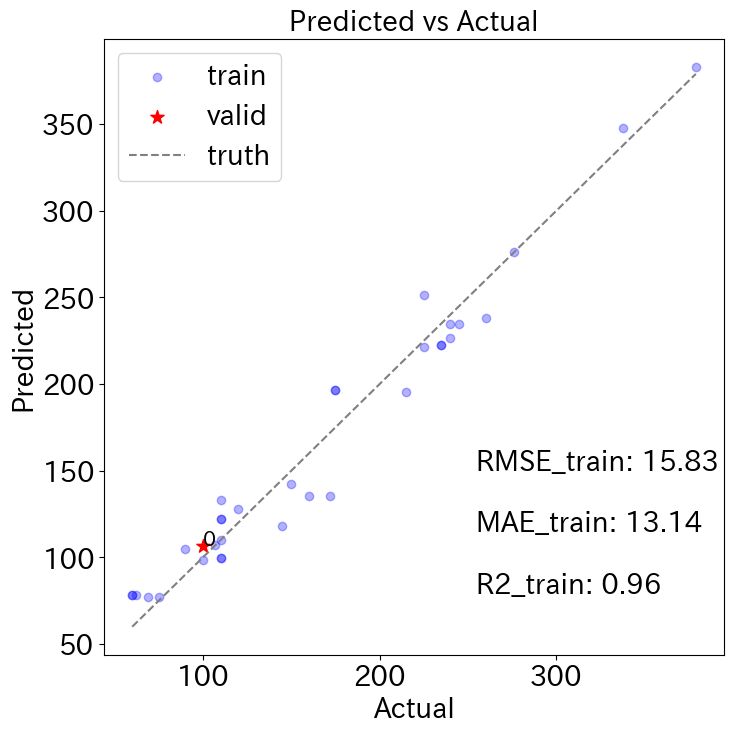

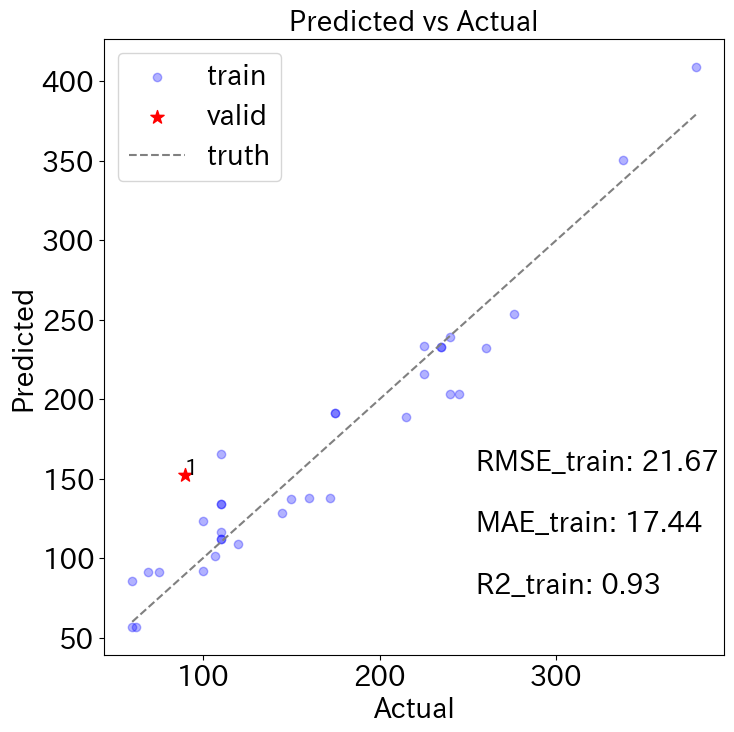

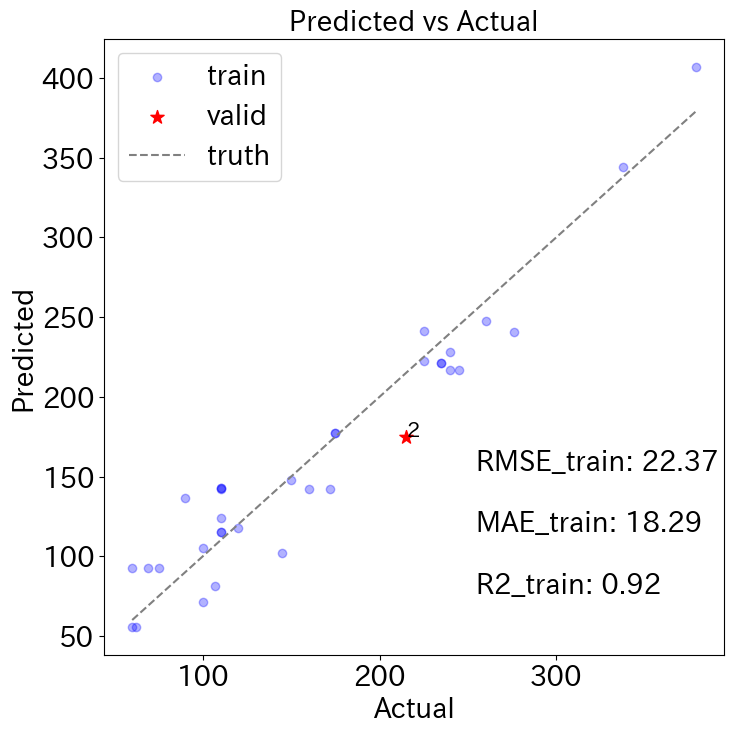

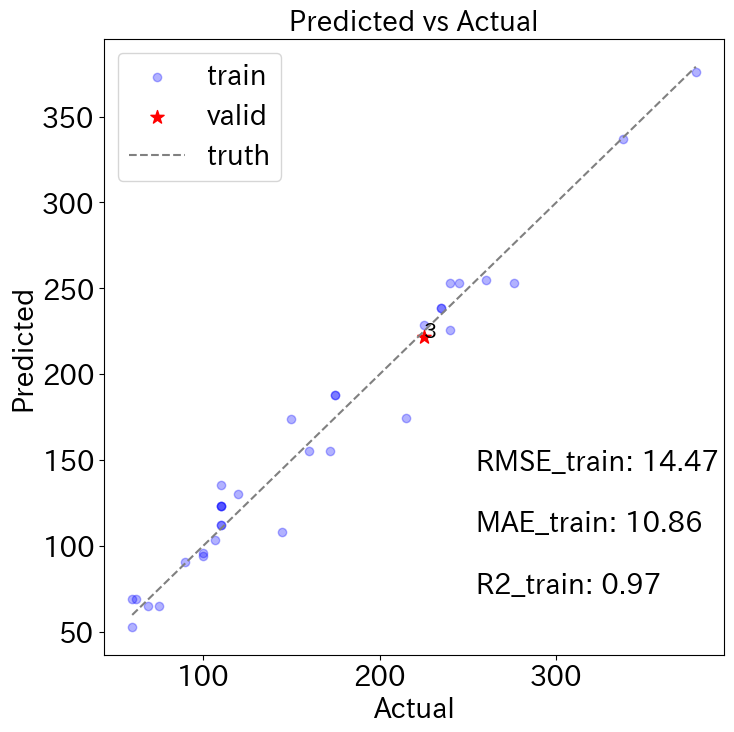

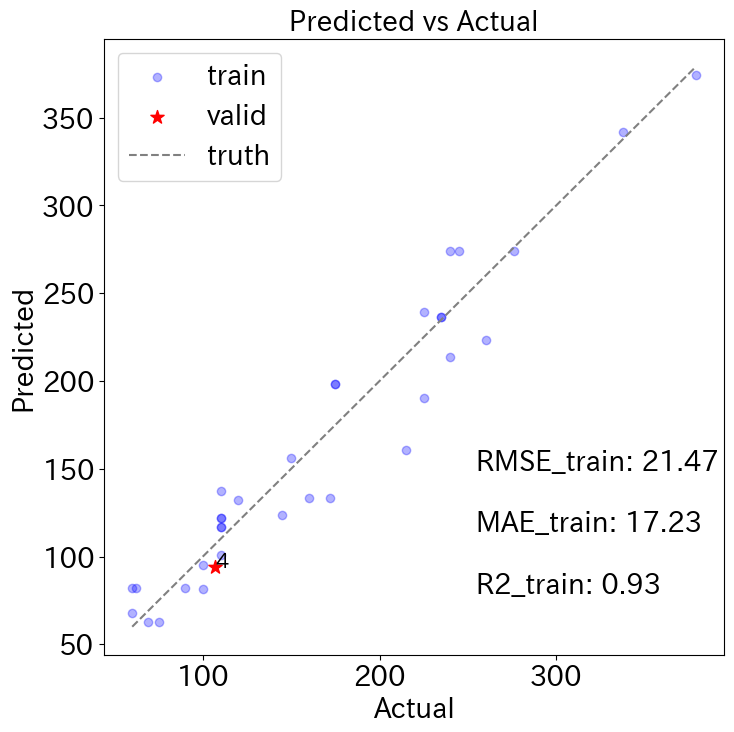

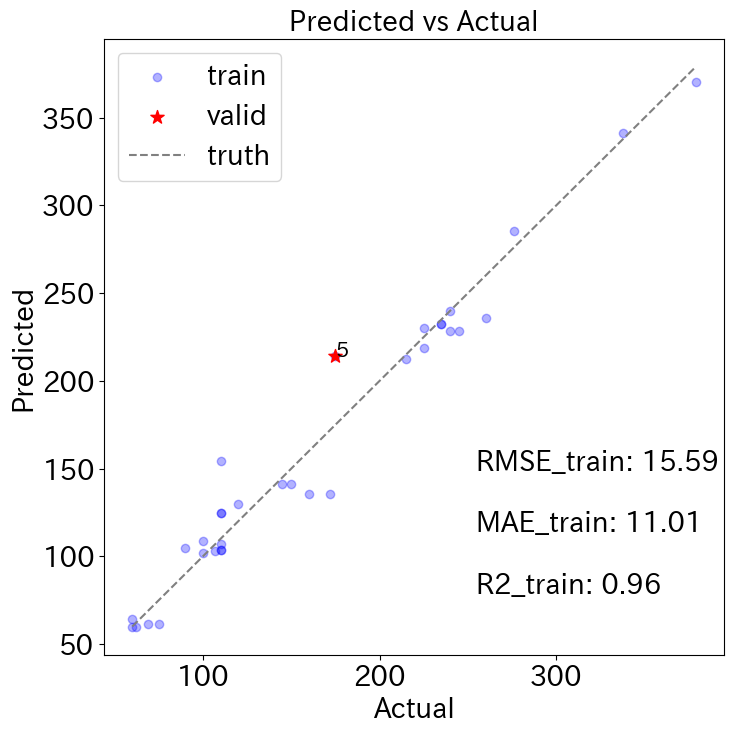

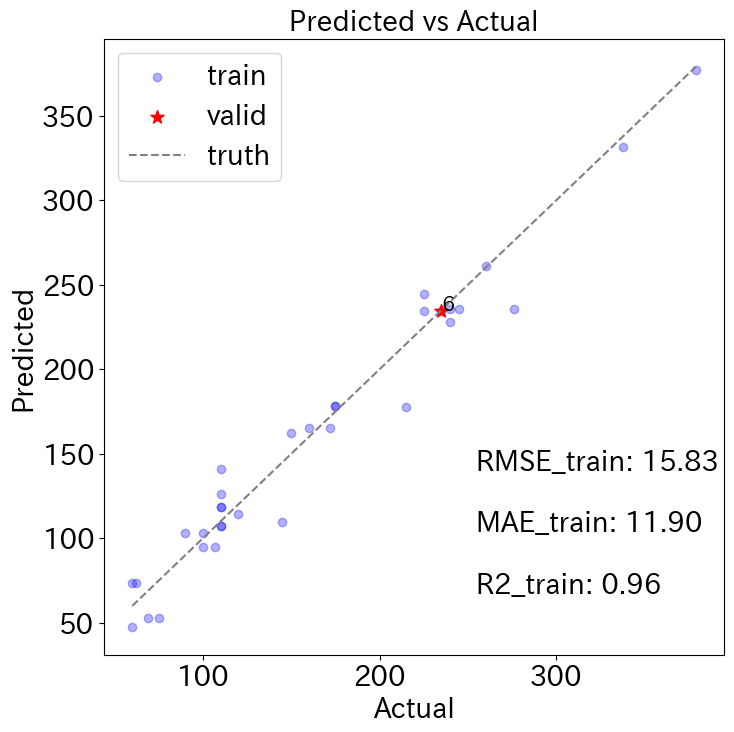

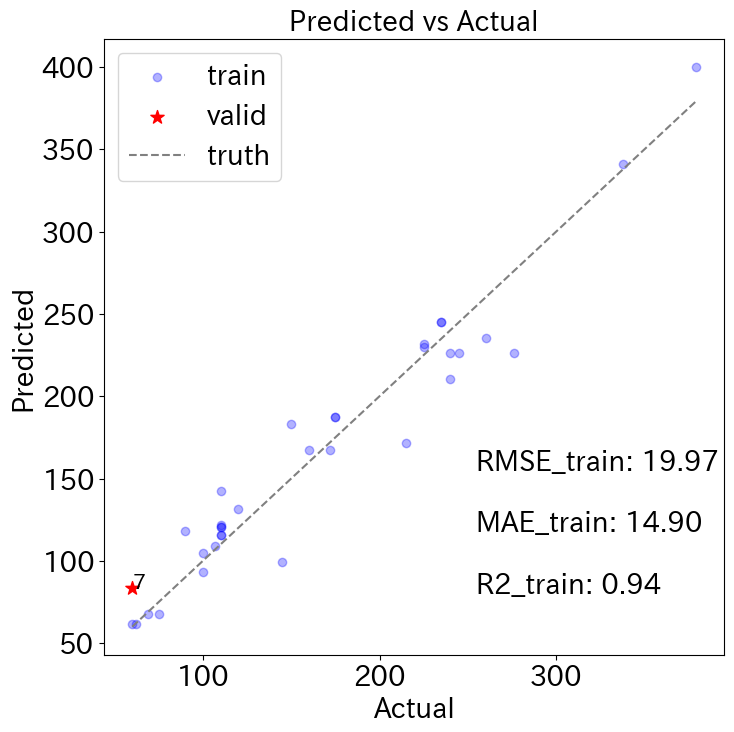

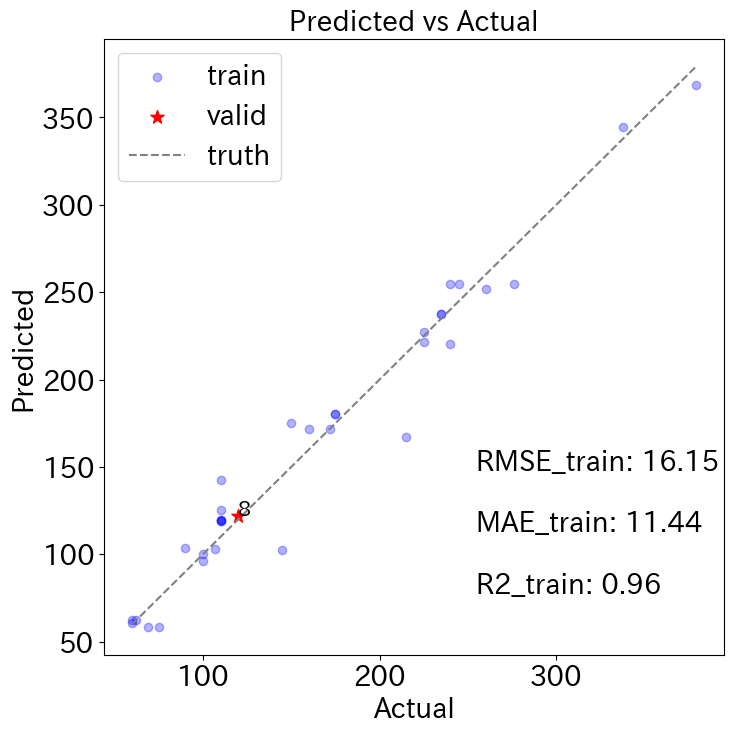

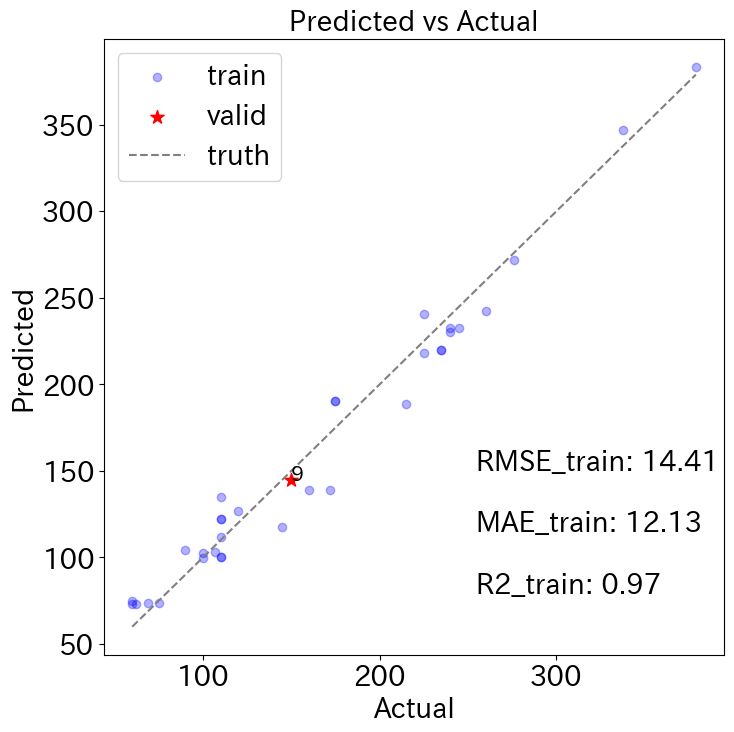

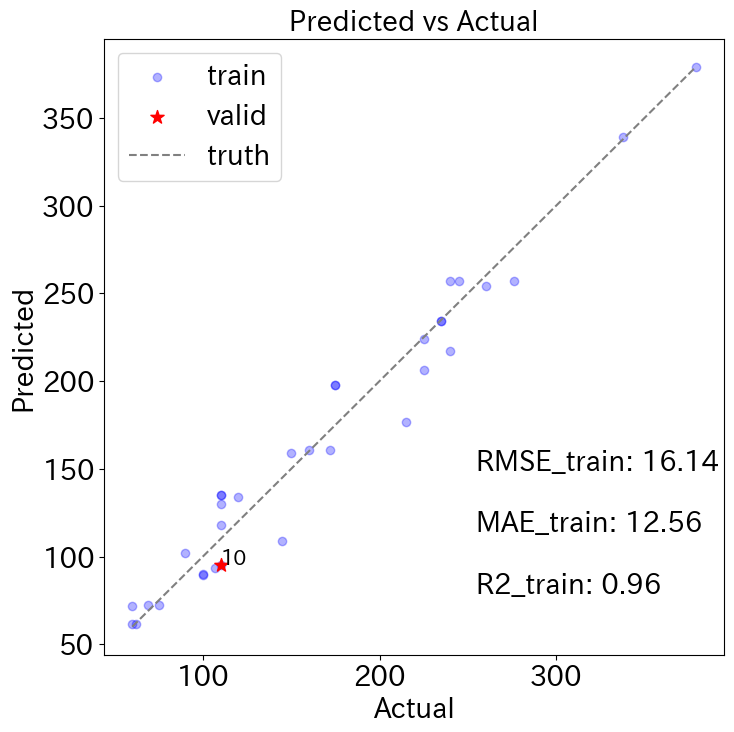

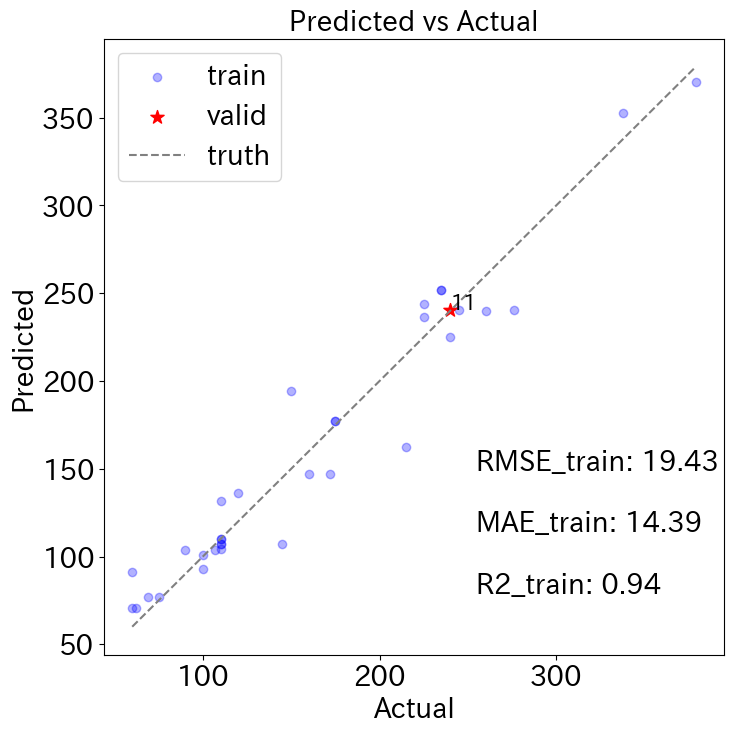

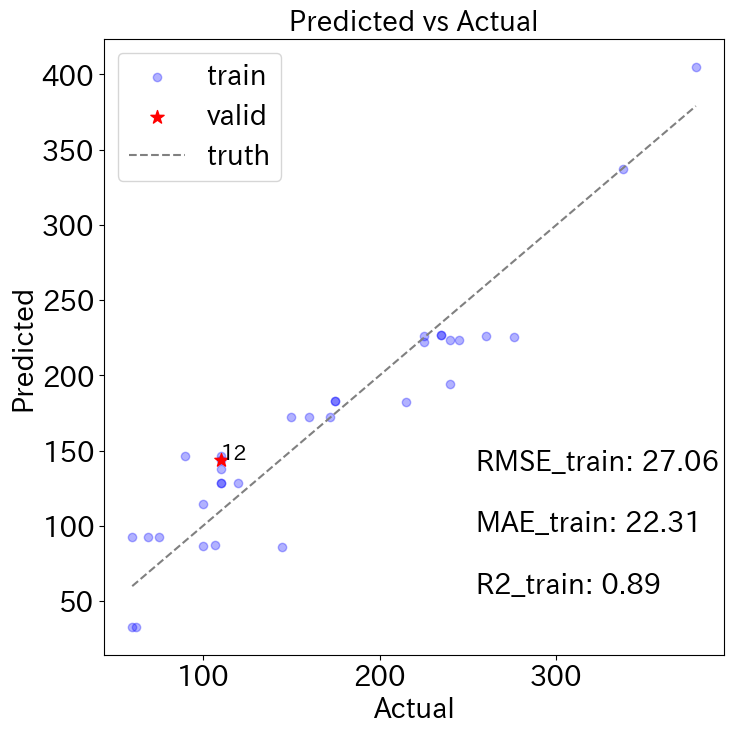

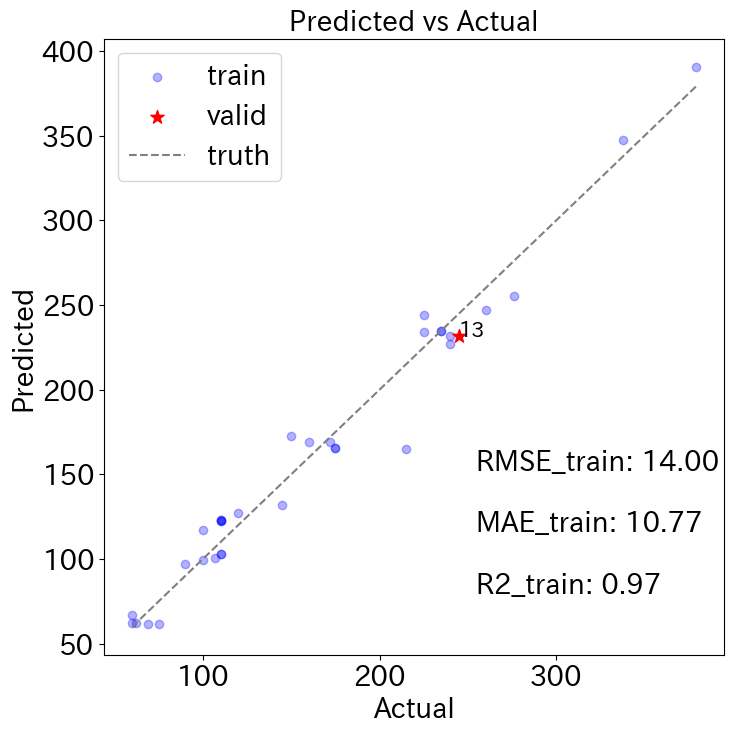

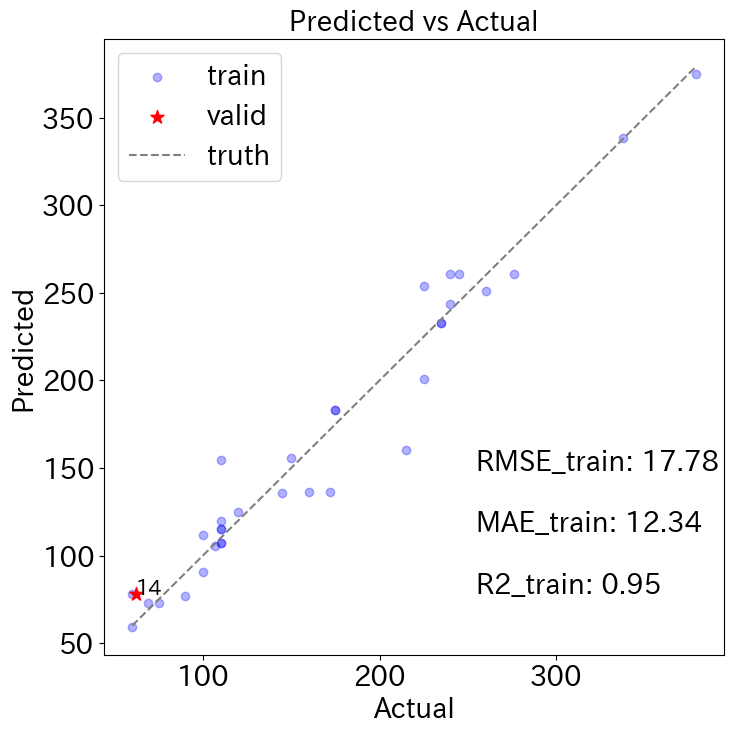

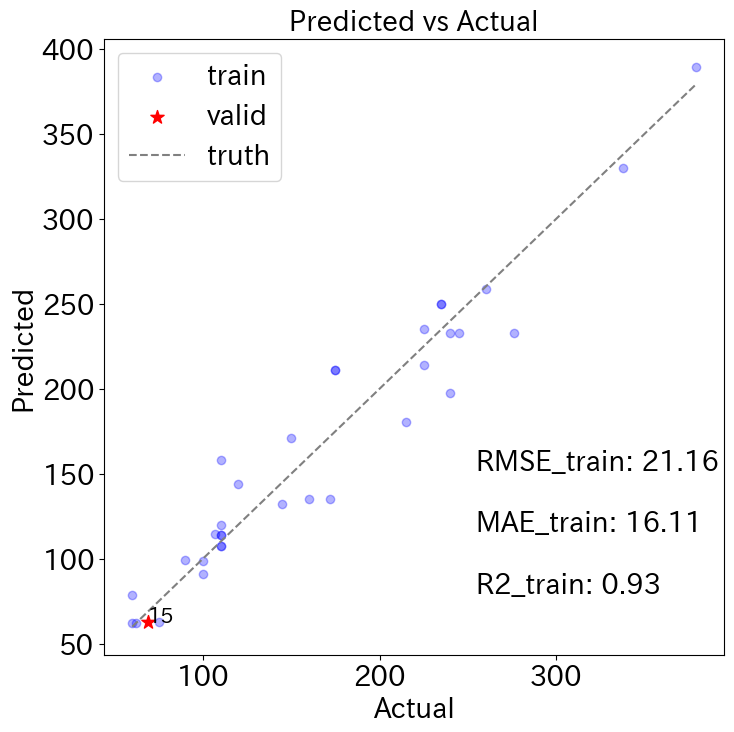

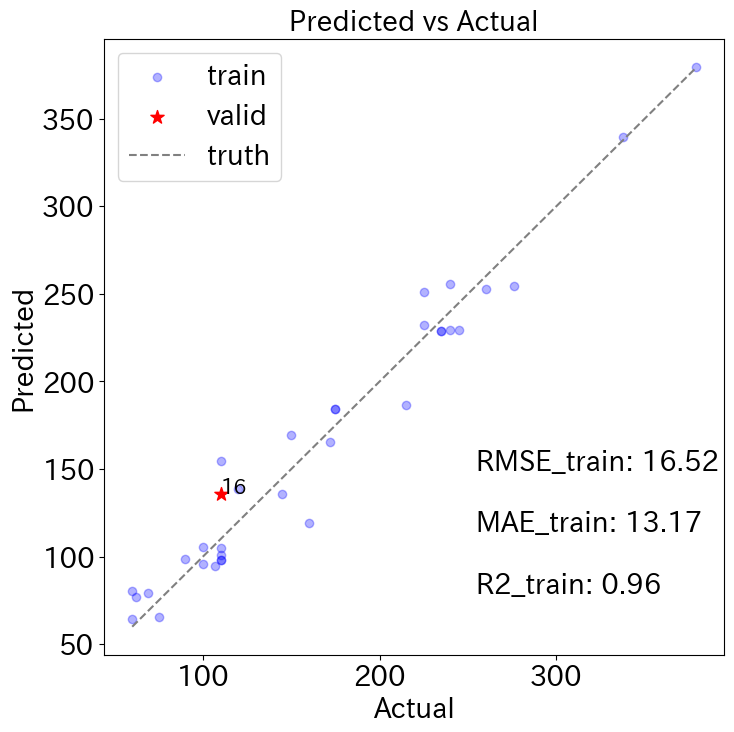

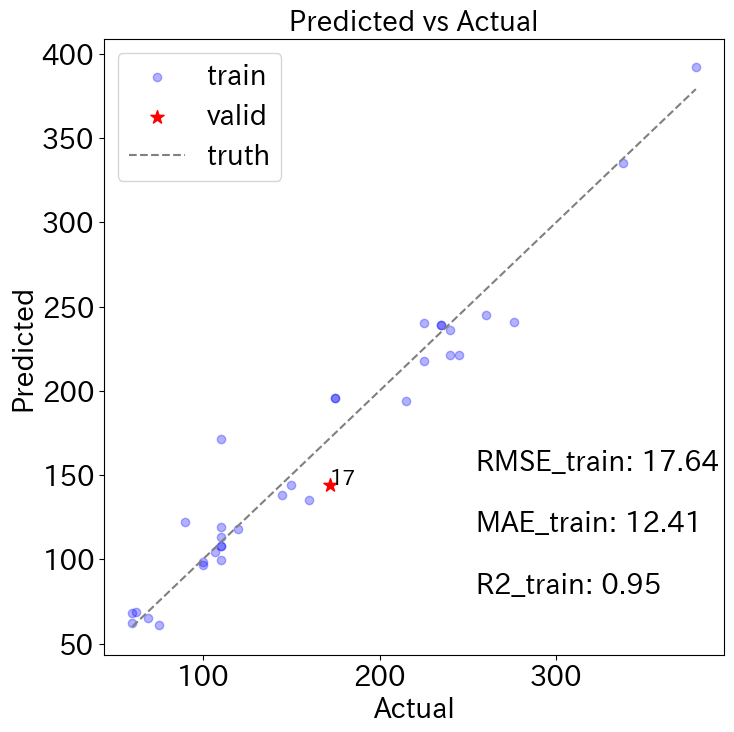

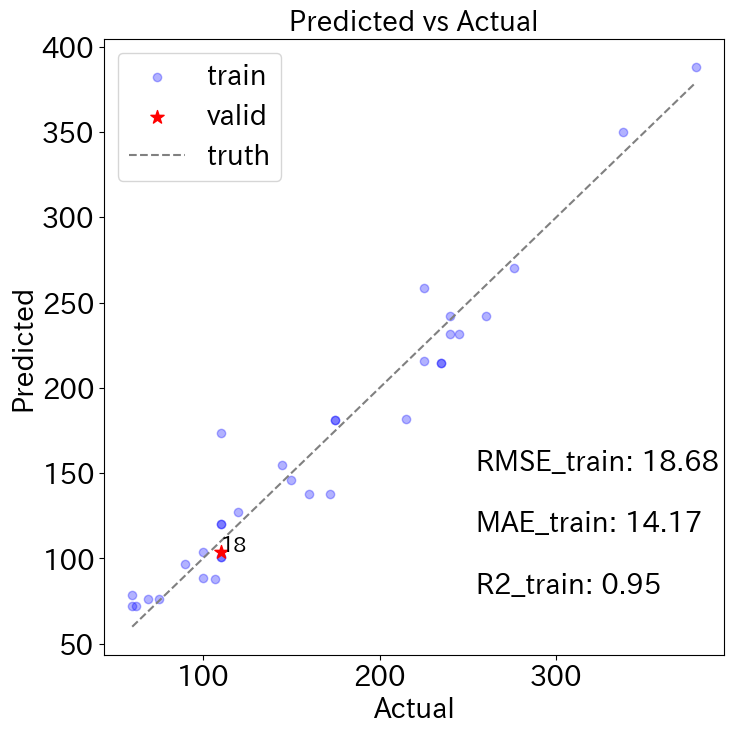

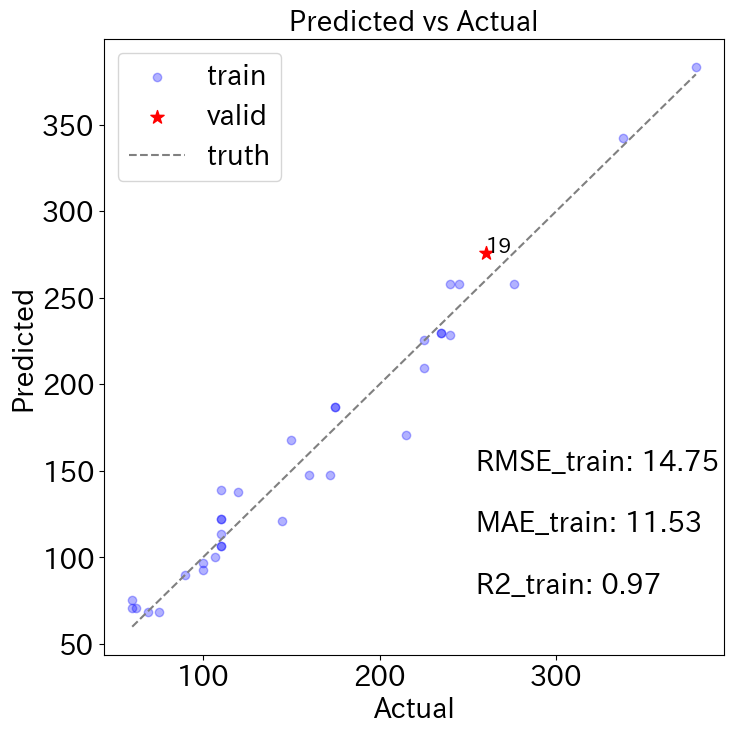

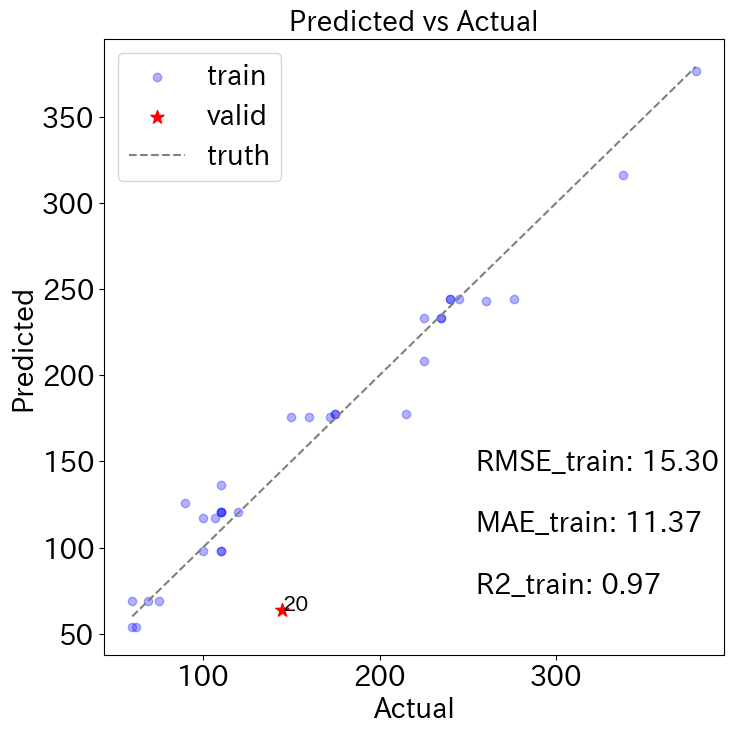

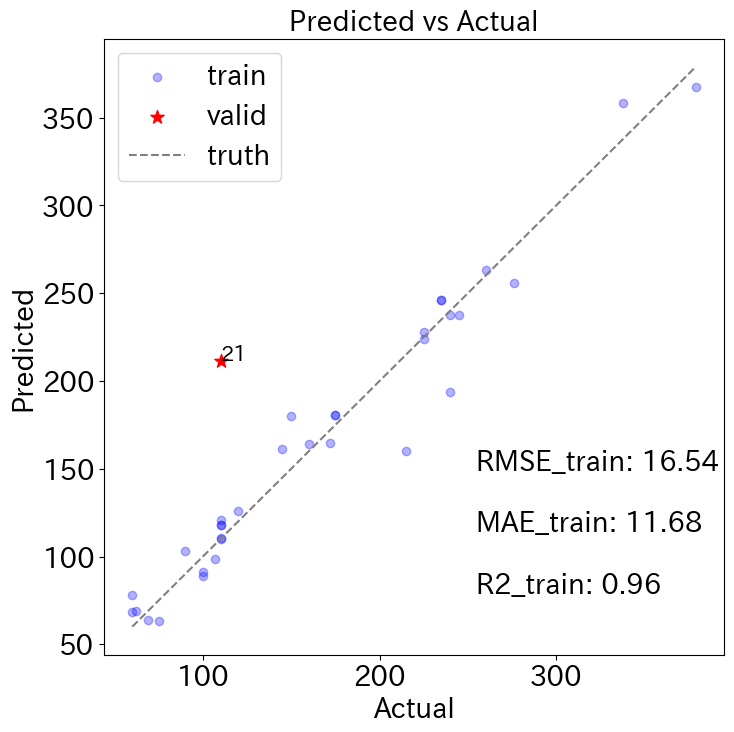

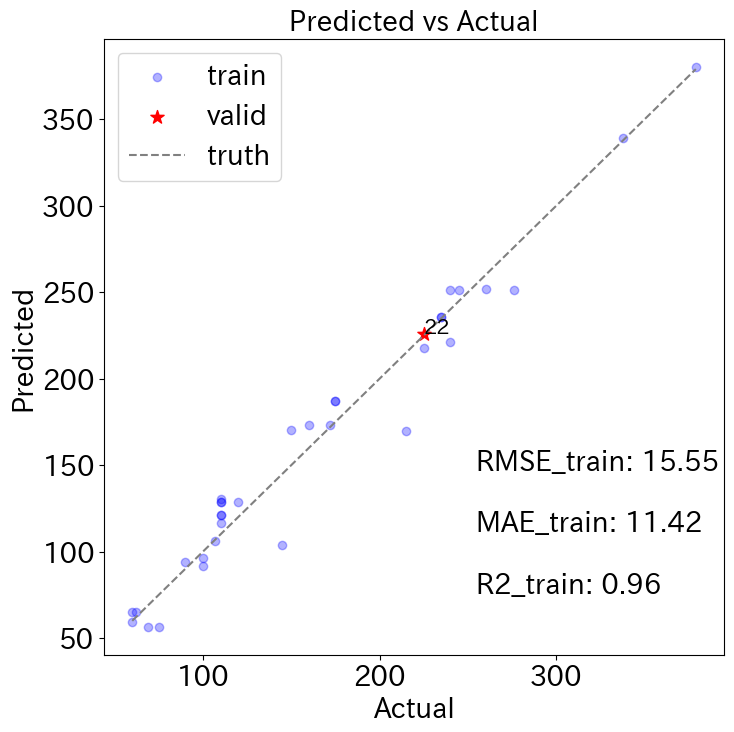

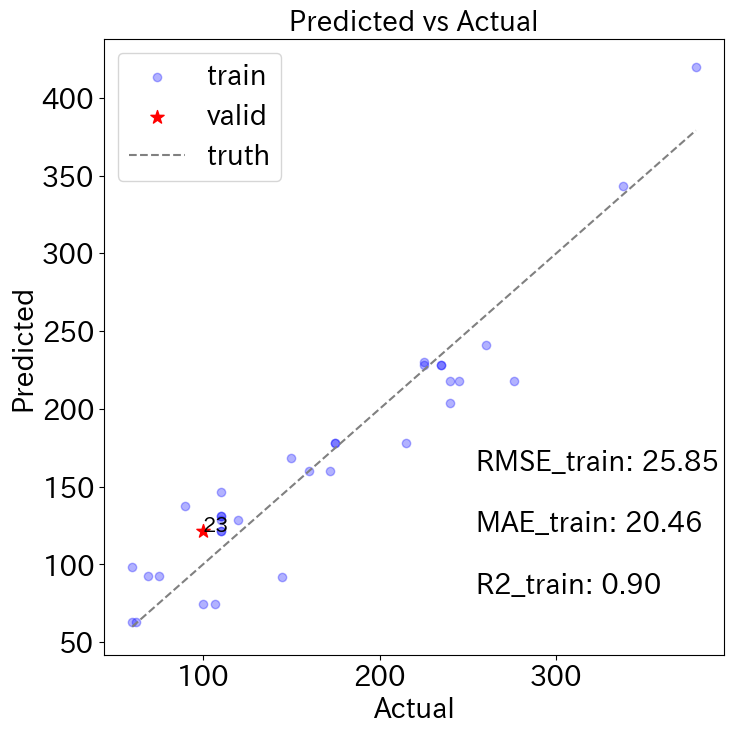

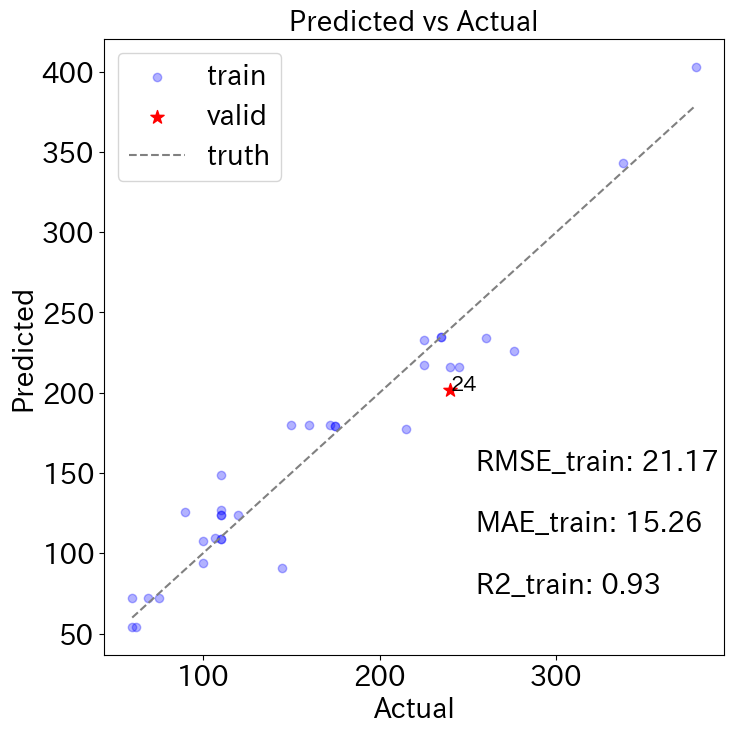

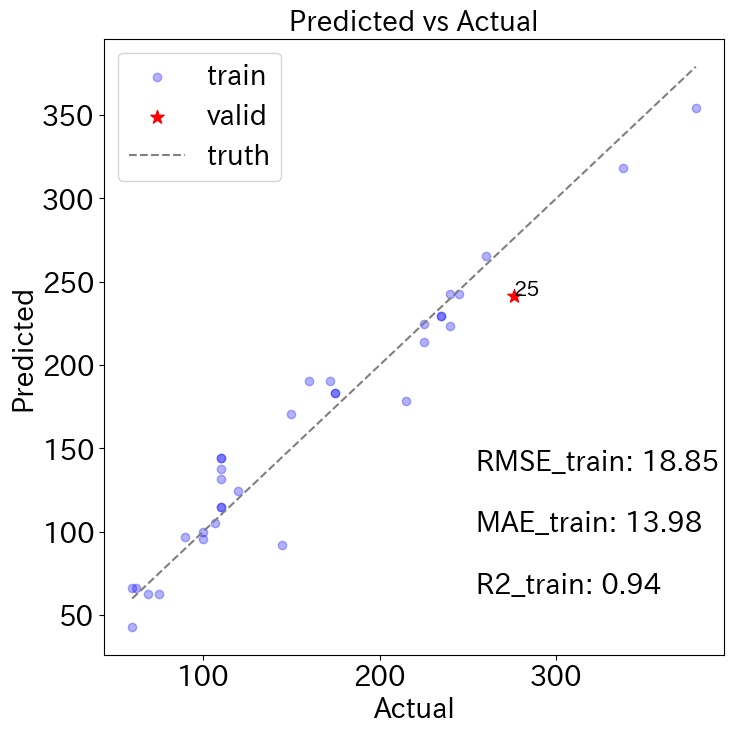

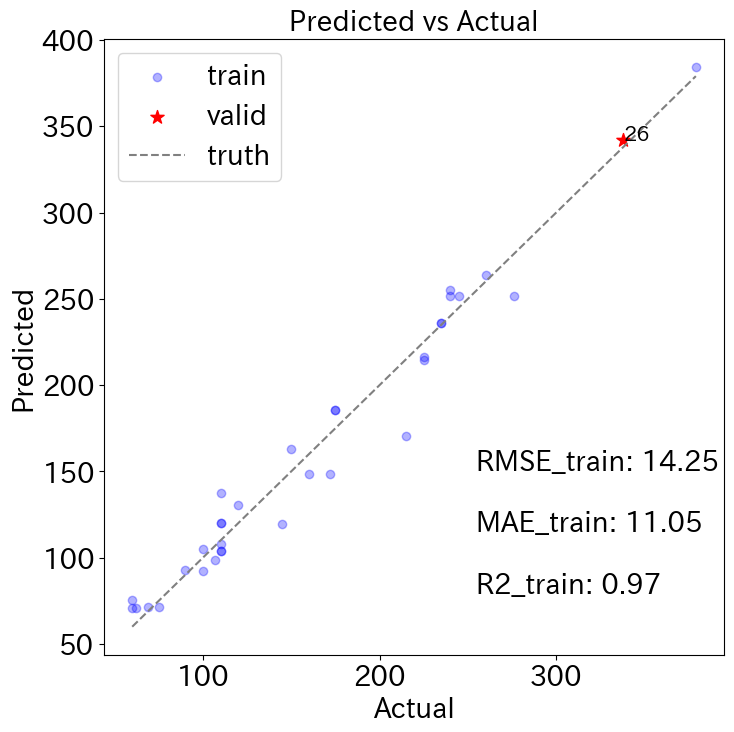

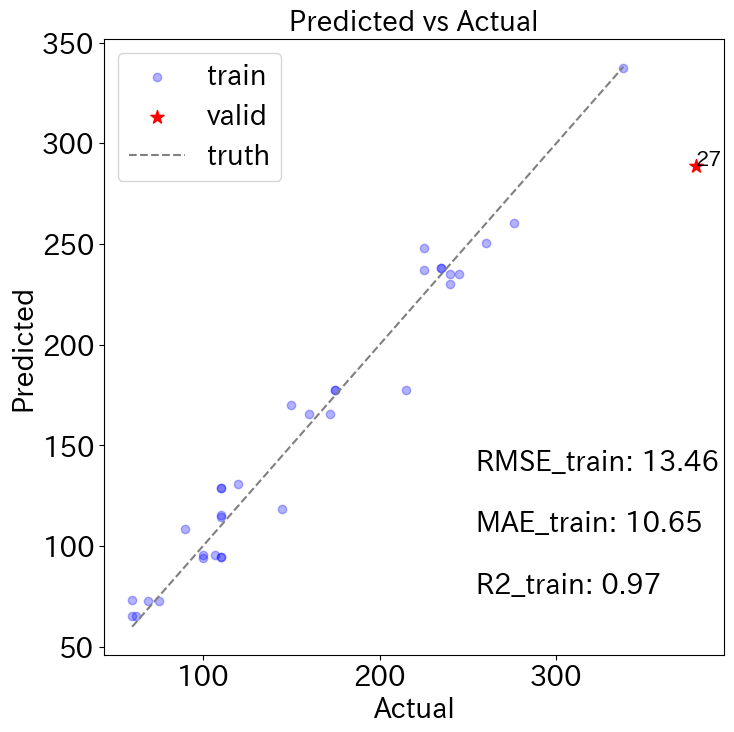

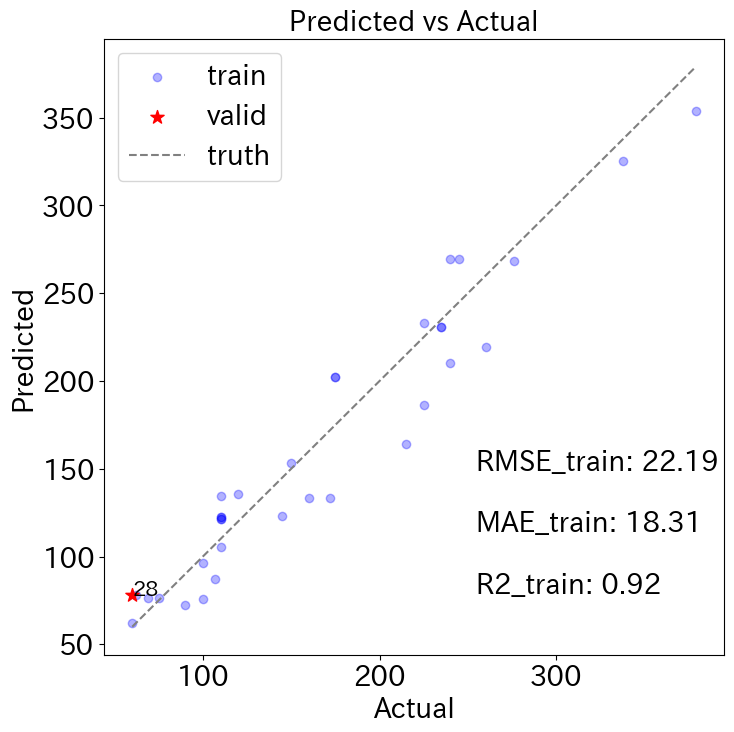

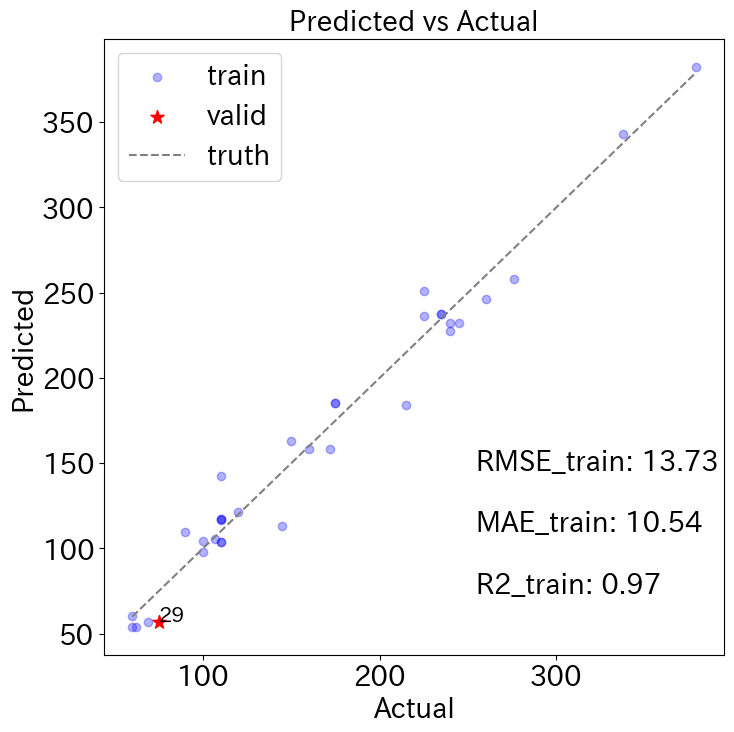

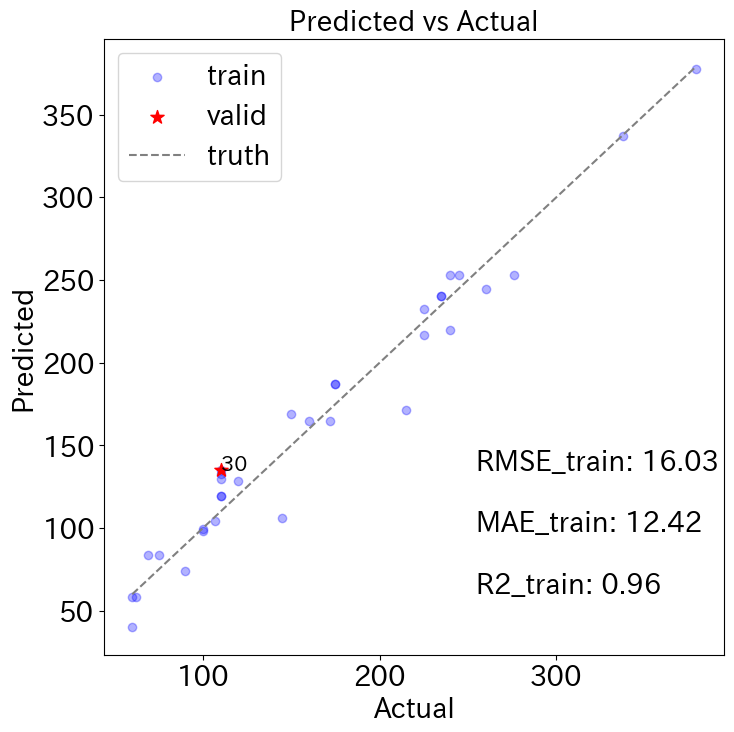

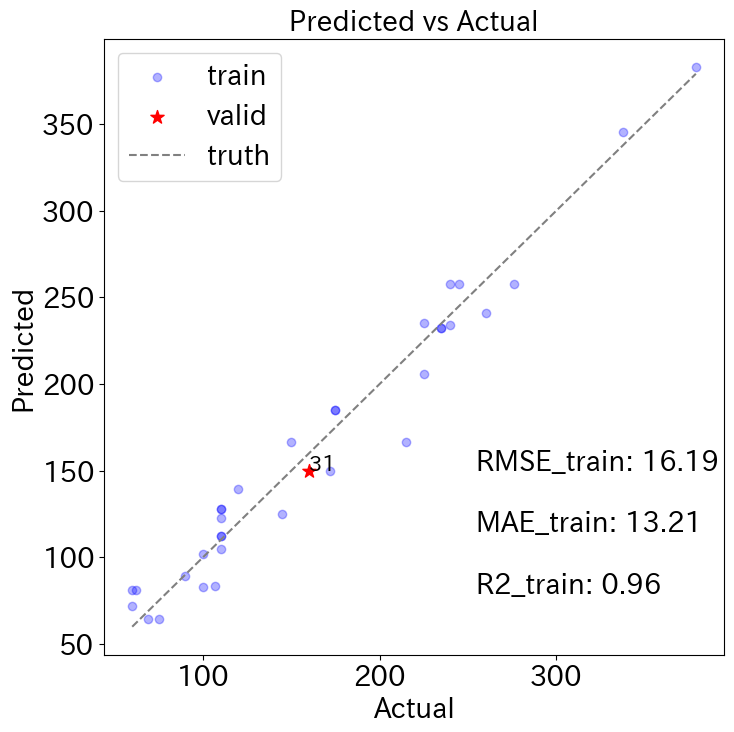

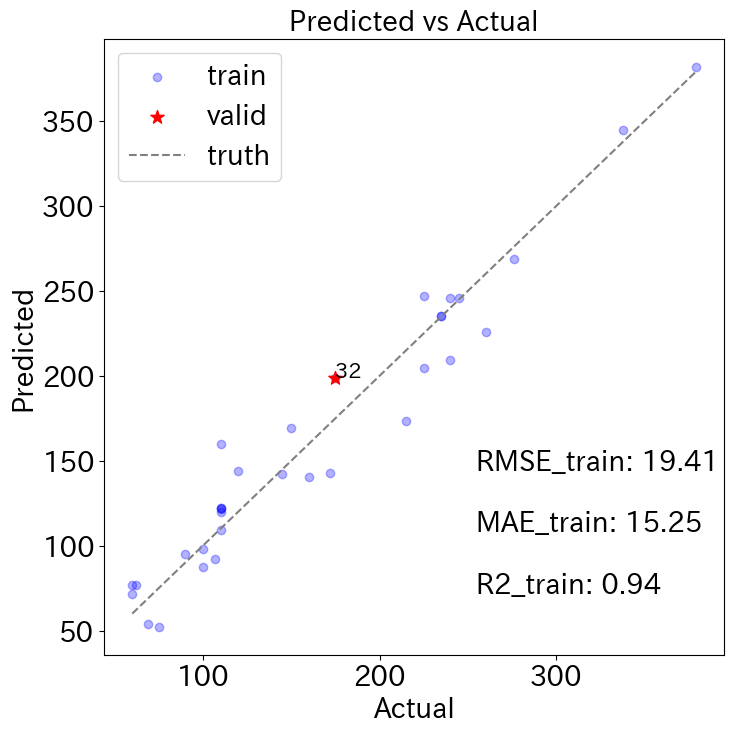

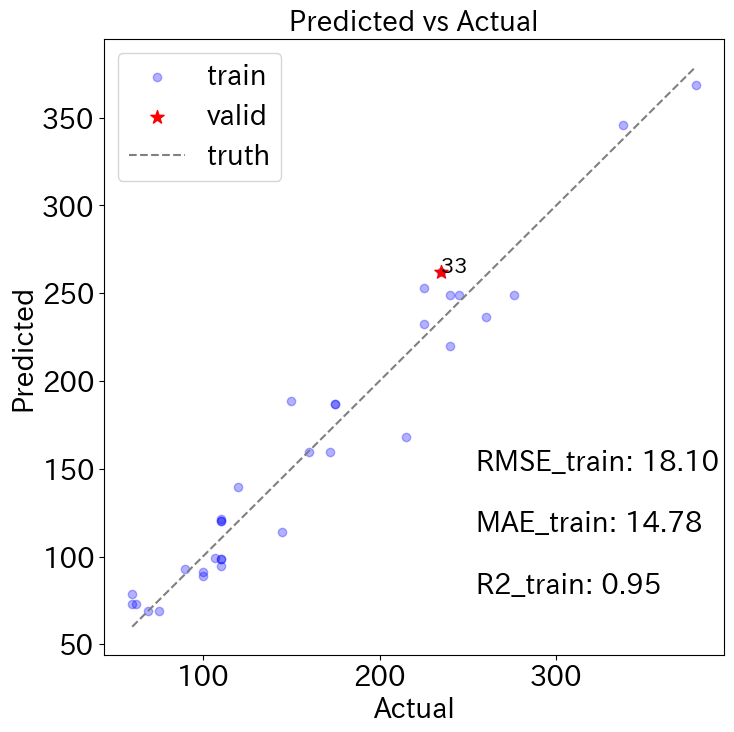

  - outputs/20250703_115323_nyhMFr/hall_of_fame.csv


In [31]:
models = []
rmses_train = []
maes_train = []
r2_train = []
rmses_valid = []
maes_valid = []
r2_valid = []
oof = np.zeros(len(train_X))

model = PySRRegressor()

folds = len(train_X)
kf = KFold(n_splits=folds)

for train_index, valid_index in tqdm(kf.split(train_X)):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[valid_index]
    y_train = train_Y.iloc[train_index].values.reshape(-1, 1)
    y_valid = train_Y.iloc[valid_index].values.reshape(-1, 1)

    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train).reshape(-1, 1)
    y_pred_valid = model.predict(X_valid).reshape(-1, 1)

    tmp_rmses_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    tmp_maes_train = mean_absolute_error(y_train, y_pred_train)
    tmp_r2_train = r2_score(y_train, y_pred_train)

    tmp_rmses_valid = np.sqrt(mean_squared_error(y_valid, y_pred_valid))
    tmp_maes_valid = mean_absolute_error(y_valid, y_pred_valid)
    tmp_r2_valid = r2_score(y_valid, y_pred_valid)

    print(train_Y.iloc[valid_index].index)
    print("RMSE_train:", tmp_rmses_train)
    print("MAE_train:", tmp_maes_train)
    print("R2_train:", tmp_r2_train)
    # print("RMSE_valid:", tmp_rmses_valid)
    # print("MAE_valid:", tmp_maes_valid)
    # print("R2_valid:", tmp_r2_valid)

    models.append(model)
    rmses_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    maes_train.append(mean_absolute_error(y_train, y_pred_train))
    r2_train.append(r2_score(y_train, y_pred_train))
    # rmses_valid.append(np.sqrt(mean_squared_error(y_valid, y_pred_valid)))
    # maes_valid.append(mean_absolute_error(y_valid, y_pred_valid))
    # r2_valid.append(r2_score(y_valid, y_pred_valid))

    oof[valid_index] = y_pred_valid

    plt.figure(figsize=(8, 8))
    plt.title("Predicted vs Actual")
    plt.scatter(y_train, y_pred_train, label="train", color="blue", alpha=0.3)
    plt.scatter(y_valid, y_pred_valid, label="valid", color="red", marker="*", s=100)
    x_truth = np.arange(y_train.min(), y_train.max() + 1)
    y_truth = x_truth
    plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
    # plt.textでRMSE, MAE, R2を右下に表示
    plt.text(
        0.6, 0.3, f"RMSE_train: {tmp_rmses_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(
        0.6, 0.2, f"MAE_train: {tmp_maes_train:.2f}", transform=plt.gca().transAxes
    )
    plt.text(0.6, 0.1, f"R2_train: {tmp_r2_train:.2f}", transform=plt.gca().transAxes)
    # plt.txtでvalid_indexに対応するサンプルIDを表示
    for i, txt in enumerate(data.iloc[valid_index].index):
        plt.text(y_valid[i], y_pred_valid[i], txt, fontsize=15)

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.legend()

### Out-Of-Fold(OOF)のプロット

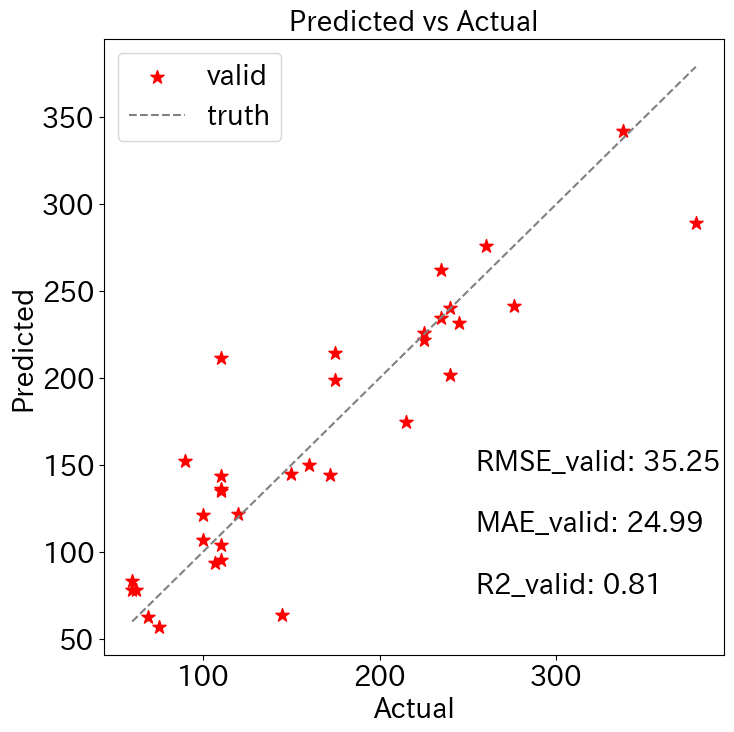

In [32]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
plt.legend()

### Out-Of-Fold(OOF)のプロット&各水準のIDを表示

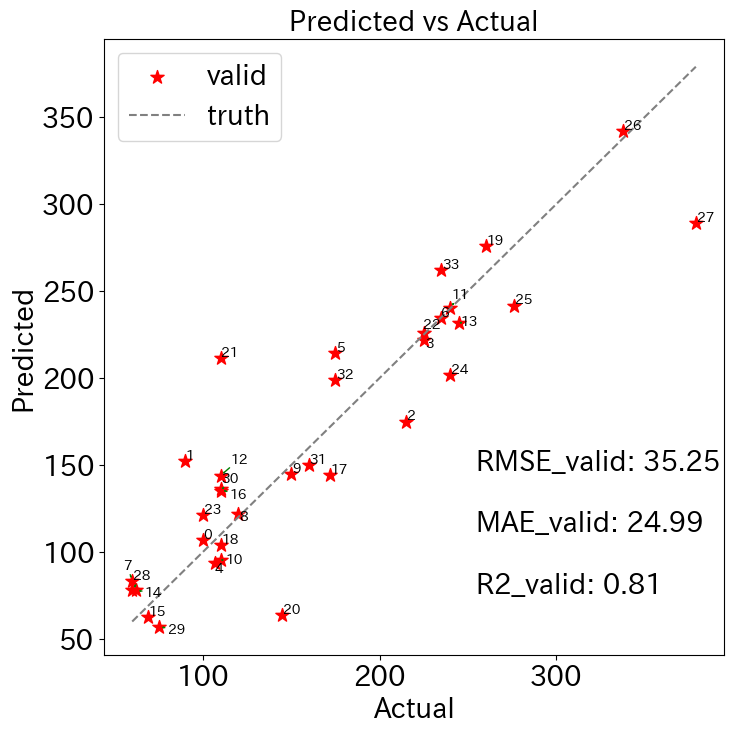

In [33]:
# oofをActualとPredictedに分けてプロット
plt.figure(figsize=(8, 8))
plt.title(f"Predicted vs Actual")
plt.scatter(train_Y, oof, label="valid", color="red", marker="*", s=100)
x_truth = np.arange(train_Y.values.min(), train_Y.values.max() + 1)
y_truth = x_truth
plt.plot(x_truth, y_truth, "--", color="gray", label="truth")
plt.xlabel("Actual")
plt.ylabel("Predicted")
# plt.textでRMSE, MAE, R2を右下に表示
plt.text(
    0.6,
    0.3,
    f"RMSE_valid: {np.sqrt(mean_squared_error(train_Y, oof)):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6,
    0.2,
    f"MAE_valid: {mean_absolute_error(train_Y, oof):.2f}",
    transform=plt.gca().transAxes,
)
plt.text(
    0.6, 0.1, f"R2_valid: {r2_score(train_Y, oof):.2f}", transform=plt.gca().transAxes
)
# plt.txtでvalid_indexに対応するサンプルIDを表示、adjustTextモジュールを使用して、重なりがないように表示
texts = [
    plt.text(train_Y.values[i], oof[i], data.index[i], fontsize=10)
    for i in range(len(train_Y))
]
adjust_text(texts, arrowprops=dict(arrowstyle="->", color="green"))
plt.legend()

In [34]:
model_all = PySRRegressor()
model_all.fit(train_X, train_Y)

[ Info: Started!



Expressions evaluated per second: 1.070e+05
Progress: 612 / 3100 total iterations (19.742%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           6.550e+03  0.000e+00  y = 164.51
3           2.729e+03  4.376e-01  y = X * 33.351
5           1.557e+03  2.803e-01  y = (Zn_wtper * 323.42) * X
7           1.218e+03  1.230e-01  y = ((Zn_wtper * 223.02) + 11.112) * X
11          1.105e+03  2.425e-02  y = ((X + (Al_wtper * Zn_wtper)) / 0.49183) * (X + Mn_wtpe...
                                      r)
13          1.089e+03  7.343e-03  y = (((X + (Al_wtper * Zn_wtper)) / 0.49183) + Mg_wtper) *...
                                       (X + Mn_wtper)
15          1.073e+03  7.353e-03  y = Mg_wtper + ((((Mn_wtper + X) + (Al_wtper * Zn_wtper)) ...
                                      / 0.49183) * 

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          164.50694   
	1         0.437847                                       X * 33.35094   
	2         0.280363                         (X * Zn_wtper) * 323.41187   
	3         0.123082           ((Zn_wtper * 223.02515) + 11.111905) * X   
	4         0.127764     ((X * Zn_wtper) * (X * 33.726627)) + 71.126724   
	5         0.051207  (X * (((Zn_wtper * 32.917004) + Mn_wtper) * X)...   
	6         0.041032  (X * ((((Zn_wtper * 10.999859) + Mn_wtper) * X...   
	7         0.002996  ((X * ((Mn_wtper + (Zn_wtper * 14.093575)) * (...   
	8         0.005916  ((((Cu_wtper - 3.5379357) * X) * ((Zn_wtper * ...   
	9         0.132359  ((17.973604 - (Zn_wtper * (X / Mn_wtper))) * (...   
	10        0.147968  ((((X + -5.094489) * (X * (19.693745 - (Zn_wtp...   
	11        0.027882  ((((Cu_wtper * 2.7664058) + Mn_wtper) * 94.920...   
	12  >>>>  0.115021  ((Si_wtper + ((Cu_wtper * 2.6218047) - 0.46474...   
	13        0.022933  (((((Cu_wtper * 2.3636878) + Si_wtper) - 1.506...   
	14        0.042955  ((((18.203705 - ((Zn_wtper * X) / Mn_wtper)) *...   
	
	          loss  complexity  
	0   6550.01400           1  
	1   2728.55660           3  
	2   1557.44580           5  
	3   1217.60140           7  
	4    943.04050           9  
	5    851.24170          11  
	6    784.17530          13  
	7    779.49005          15  
	8    770.32086          17  
	9    591.16150          19  
	10   439.72687          21  
	11   415.87698          23  
	12   330.41450          25  
	13   315.60226          27  
	14   289.62094          29  
]

  - outputs/20250703_115404_8CgVZn/hall_of_fame.csv


In [38]:
model_all

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          164.50694   
	1         0.437847                                       X * 33.35094   
	2         0.280363                         (X * Zn_wtper) * 323.41187   
	3         0.123082           ((Zn_wtper * 223.02515) + 11.111905) * X   
	4         0.127764     ((X * Zn_wtper) * (X * 33.726627)) + 71.126724   
	5         0.051207  (X * (((Zn_wtper * 32.917004) + Mn_wtper) * X)...   
	6         0.041032  (X * ((((Zn_wtper * 10.999859) + Mn_wtper) * X...   
	7         0.002996  ((X * ((Mn_wtper + (Zn_wtper * 14.093575)) * (...   
	8         0.005916  ((((Cu_wtper - 3.5379357) * X) * ((Zn_wtper * ...   
	9         0.132359  ((17.973604 - (Zn_wtper * (X / Mn_wtper))) * (...   
	10        0.147968  ((((X + -5.094489) * (X * (19.693745 - (Zn_wtp...   
	11        0.027882  ((((Cu_wtper * 2.7664058) + Mn_wtper) * 94.920...   
	12  >>>>  0.115021  ((Si_wtper + ((Cu_wtper * 2.6218047) - 0.46474...   
	13        0.022933  (((((Cu_wtper * 2.3636878) + Si_wtper) - 1.506...   
	14        0.042955  ((((18.203705 - ((Zn_wtper * X) / Mn_wtper)) *...   
	
	          loss  complexity  
	0   6550.01400           1  
	1   2728.55660           3  
	2   1557.44580           5  
	3   1217.60140           7  
	4    943.04050           9  
	5    851.24170          11  
	6    784.17530          13  
	7    779.49005          15  
	8    770.32086          17  
	9    591.16150          19  
	10   439.72687          21  
	11   415.87698          23  
	12   330.41450          25  
	13   315.60226          27  
	14   289.62094          29  
]

In [39]:
model_all.get_best()

complexity                                                      25
loss                                                      330.4145
equation         ((Si_wtper + ((Cu_wtper * 2.6218047) - 0.46474...
score                                                     0.115021
sympy_format     X*(18.079443 - X*Zn_wtper/Mn_wtper)*(X - 5.176...
lambda_format    PySRFunction(X=>X*(18.079443 - X*Zn_wtper/Mn_w...
Name: 12, dtype: object

In [40]:
model_all.get_best()["equation"]

'((Si_wtper + ((Cu_wtper * 2.6218047) - 0.4647442)) * 92.93687) + (((18.079443 - ((X / Mn_wtper) * Zn_wtper)) * ((X + -5.176228) * X)) + 113.54136)'

In [41]:
oof

array([106.74241544, 152.5002528 , 174.99996343, 221.73918467,
        93.8468252 , 214.14931996, 234.73966176,  83.3138021 ,
       122.0180588 , 144.7757384 ,  95.4465317 , 240.50380065,
       143.92573775, 231.7212524 ,  77.92778574,  62.52841843,
       136.0362182 , 144.16641124, 103.9508734 , 275.97005849,
        63.51960967, 211.45031783, 226.04078993, 121.43878063,
       201.73487683, 241.69568504, 341.91796827, 288.91654434,
        78.02989817,  57.01338879, 134.86093249, 150.08097143,
       198.8262284 , 262.04242826])

### 実行環境の確認及び保存

In [42]:
!python3 -V

Python 3.11.13


In [43]:
!pip freeze > requirements_symbolic.txt

In [44]:
from google.colab import files

files.download('requirements_symbolic.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>